# Esteira de Aprendizado de Máquina - Predição de Diabetes

Este notebook implementa uma esteira completa de aprendizado de máquina para diagnóstico de diabetes, utilizando o dataset Pima Indians Diabetes. Contém todas as etapas desde análise exploratória, transformações de dados, divisão em três conjuntos (treino/validação/teste), treinamento do modelo, avaliação e predição de novos casos.

## 1. Importação de Bibliotecas Necessárias

Importe as bibliotecas essenciais para análise de dados, visualização e machine learning.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
import joblib

# Configurações de visualização
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8, 5)

## 2. Carregamento e Visualização Inicial do Dataset

Vamos carregar o dataset Pima Indians Diabetes e visualizar suas primeiras linhas, além de informações básicas.

In [3]:
# Carregar o dataset
url = 'https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv'
df = pd.read_csv(url)

print(f"Dataset carregado: {df.shape[0]} linhas, {df.shape[1]} colunas.")
df.head()

Dataset carregado: 768 linhas, 9 colunas.


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [16]:
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np

# NOVA ABORDAGEM: LIMPEZA KNN COM EXCLUSÕES ESPECÍFICAS
print("🔄 NOVA ABORDAGEM: LIMPEZA KNN COM EXCLUSÕES ESPECÍFICAS")
print("="*80)


# ETAPA 1: CRIAR CÓPIA DO DATASET ORIGINAL PARA LIMPEZA
print(f"\n📊 INICIANDO LIMPEZA ESPECÍFICA:")
print(f"   Dataset original: {df.shape}")

df_knn_exclusao = df.copy()

# ETAPA 2: REMOVER COLUNA INSULIN (ALTA % DE ZEROS)
print(f"\n🗑️ REMOÇÃO DA COLUNA INSULIN:")
insulin_zeros = (df_knn_exclusao['Insulin'] == 0).sum()
insulin_pct = (insulin_zeros / len(df_knn_exclusao)) * 100
print(f"   Zeros em Insulin: {insulin_zeros} ({insulin_pct:.1f}%)")
print(f"   Justificativa: Alto percentual de zeros (>45%)")

df_knn_exclusao = df_knn_exclusao.drop(['Insulin'], axis=1)
print(f"   Shape após remoção: {df_knn_exclusao.shape}")

# ETAPA 3: IDENTIFICAR E REMOVER LINHAS COM BMI = 0
print(f"\n🔍 ANÁLISE DE BMI ZERO:")
bmi_zero_mask = df_knn_exclusao['BMI'] == 0
bmi_zero_count = bmi_zero_mask.sum()
print(f"   Linhas com BMI = 0: {bmi_zero_count}")

if bmi_zero_count > 0:
    print(f"   Características das linhas com BMI = 0:")
    bmi_zero_records = df_knn_exclusao[bmi_zero_mask]
    
    # Mostrar alguns exemplos
    print(f"   Índices: {list(bmi_zero_records.index)}")
    
    # Analisar distribuição por outcome
    diabetic_bmi_zero = bmi_zero_records[bmi_zero_records['Outcome'] == 1].shape[0]
    print(f"   Diabéticos com BMI=0: {diabetic_bmi_zero}")
    print(f"   Não diabéticos com BMI=0: {bmi_zero_count - diabetic_bmi_zero}")
    
    # REMOVER LINHAS COM BMI = 0
    print(f"\n🗑️ REMOVENDO LINHAS COM BMI = 0:")
    df_knn_exclusao = df_knn_exclusao[~bmi_zero_mask].copy()
    print(f"   Shape após remoção: {df_knn_exclusao.shape}")
    print(f"   Linhas removidas: {bmi_zero_count}")

# ETAPA 4: ANÁLISE DOS ZEROS RESTANTES
print(f"\n📊 ANÁLISE DOS ZEROS RESTANTES:")
variables_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']

zeros_analysis = {}
for var in variables_to_check:
    zeros_count = (df_knn_exclusao[var] == 0).sum()
    zeros_pct = (zeros_count / len(df_knn_exclusao)) * 100
    zeros_analysis[var] = {'count': zeros_count, 'percent': zeros_pct}
    
    print(f"   {var}: {zeros_count} zeros ({zeros_pct:.1f}%)")

# ETAPA 5: PREPARAR DADOS PARA KNN IMPUTATION
print(f"\n🔧 PREPARAÇÃO PARA KNN IMPUTATION:")

# Separar features (X) e target (y)
feature_cols = [col for col in df_knn_exclusao.columns if col != 'Outcome']
X_knn = df_knn_exclusao[feature_cols].copy()
y_knn = df_knn_exclusao['Outcome'].copy()

print(f"   Features para imputação: {feature_cols}")
print(f"   Shape de X: {X_knn.shape}")

# Converter zeros problemáticos para NaN
print(f"\n🔄 CONVERSÃO DE ZEROS PARA NaN:")
variables_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness']  # BMI não tem zeros após remoção

for var in variables_to_impute:
    zeros_before = (X_knn[var] == 0).sum()
    X_knn.loc[X_knn[var] == 0, var] = np.nan
    nan_after = X_knn[var].isna().sum()
    print(f"   {var}: {zeros_before} zeros → {nan_after} NaN")

# ETAPA 6: APLICAR KNN IMPUTATION POR GRUPO (DIABÉTICO/NÃO DIABÉTICO)
print(f"\n🎯 KNN IMPUTATION POR GRUPO:")

# Função para aplicar KNN por grupo
def knn_impute_by_group(X, y, n_neighbors=5):
    X_imputed = X.copy()
    
    for outcome in [0, 1]:
        group_mask = y == outcome
        X_group = X[group_mask].copy()
        
        if len(X_group) > n_neighbors and X_group.isna().sum().sum() > 0:
            # Aplicar KNN apenas no grupo
            knn = KNNImputer(n_neighbors=n_neighbors, weights='distance')
            X_group_imputed = knn.fit_transform(X_group)
            
            # Criar DataFrame com nomes das colunas
            X_group_df = pd.DataFrame(X_group_imputed, 
                                    columns=X_group.columns, 
                                    index=X_group.index)
            
            # Substituir no dataset principal
            X_imputed.loc[group_mask] = X_group_df
            
            group_name = "não diabéticos" if outcome == 0 else "diabéticos"
            missing_before = X_group.isna().sum().sum()
            print(f"   Grupo {group_name}: {missing_before} valores imputados")
    
    return X_imputed

# Aplicar KNN por grupo
X_knn_imputed = knn_impute_by_group(X_knn, y_knn, n_neighbors=5)

# ETAPA 7: RECONSTRUIR DATASET COMPLETO
print(f"\n🔨 RECONSTRUÇÃO DO DATASET:")

df_knn_final_exclusao = X_knn_imputed.copy()
df_knn_final_exclusao['Outcome'] = y_knn

print(f"   Shape final: {df_knn_final_exclusao.shape}")
print(f"   Colunas: {list(df_knn_final_exclusao.columns)}")

# ETAPA 8: VERIFICAÇÃO FINAL
print(f"\n✅ VERIFICAÇÃO FINAL:")

# Verificar valores ausentes
missing_final = df_knn_final_exclusao.isna().sum()
print(f"   Valores ausentes restantes:")
for col, missing in missing_final.items():
    if missing > 0:
        print(f"      {col}: {missing}")
    
if missing_final.sum() == 0:
    print(f"   🎉 Nenhum valor ausente!")

# Verificar zeros críticos
print(f"\n   Zeros críticos restantes:")
critical_vars = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
total_critical_zeros = 0

for var in critical_vars:
    zeros = (df_knn_final_exclusao[var] == 0).sum()
    total_critical_zeros += zeros
    if zeros > 0:
        print(f"      {var}: {zeros} zeros")

if total_critical_zeros == 0:
    print(f"   🎉 Nenhum zero crítico!")

# ETAPA 9: ESTATÍSTICAS COMPARATIVAS
print(f"\n📊 COMPARAÇÃO: ANTES vs DEPOIS:")
print(f"   Registros: {df.shape[0]} → {df_knn_final_exclusao.shape[0]} (-{df.shape[0] - df_knn_final_exclusao.shape[0]})")
print(f"   Variáveis: {df.shape[1]} → {df_knn_final_exclusao.shape[1]} (-{df.shape[1] - df_knn_final_exclusao.shape[1]})")

# Distribuição do Outcome
outcome_before = df['Outcome'].value_counts().sort_index()
outcome_after = df_knn_final_exclusao['Outcome'].value_counts().sort_index()

print(f"\n   Distribuição do Outcome:")
print(f"      Não diabéticos: {outcome_before[0]} → {outcome_after[0]} (-{outcome_before[0] - outcome_after[0]})")
print(f"      Diabéticos: {outcome_before[1]} → {outcome_after[1]} (-{outcome_before[1] - outcome_after[1]})")

# ETAPA 10: SALVAR DATASET
output_filename = 'diabetes_knn_comexclusao.csv'
df_knn_final_exclusao.to_csv(output_filename, index=False)

print(f"\n💾 DATASET SALVO:")
print(f"   Arquivo: {output_filename}")
print(f"   Tamanho: {df_knn_final_exclusao.shape}")

# ETAPA 11: RESUMO DAS TRANSFORMAÇÕES
print(f"\n📋 RESUMO DAS TRANSFORMAÇÕES APLICADAS:")
print("="*60)
print("1. ❌ INSULIN removida (alta % de zeros)")
print("2. ❌ Linhas com BMI = 0 removidas (biologicamente implausível)")
print("3. 🔄 Zeros convertidos para NaN em Glucose, BloodPressure, SkinThickness")
print("4. 🎯 KNN Imputation aplicada por grupo (diabético/não diabético)")
print("5. ✅ SkinThickness mantida e imputada")
print("6. ✅ Dataset limpo e pronto para machine learning")

print(f"\n🎯 CARACTERÍSTICAS DO DATASET FINAL:")
print("="*50)
print(f"✅ Sem valores ausentes")
print(f"✅ Sem zeros biologicamente implausíveis")
print(f"✅ Imputação respeitando grupos clínicos")
print(f"✅ Variabilidade preservada")
print(f"✅ Dataset balanceado mantido")

print(f"\n🚀 PRONTO PARA USO:")
print(f"   • Variável alvo: Outcome")
print(f"   • Features: {len(feature_cols)} variáveis")
print(f"   • Amostras: {len(df_knn_final_exclusao)} registros")
print(f"   • Arquivo: {output_filename}")

# Atualizar variável para uso posterior
df_final_knn_exclusao = df_knn_final_exclusao.copy()

🔄 NOVA ABORDAGEM: LIMPEZA KNN COM EXCLUSÕES ESPECÍFICAS

📊 INICIANDO LIMPEZA ESPECÍFICA:
   Dataset original: (768, 9)

🗑️ REMOÇÃO DA COLUNA INSULIN:
   Zeros em Insulin: 374 (48.7%)
   Justificativa: Alto percentual de zeros (>45%)
   Shape após remoção: (768, 8)

🔍 ANÁLISE DE BMI ZERO:
   Linhas com BMI = 0: 11
   Características das linhas com BMI = 0:
   Índices: [9, 49, 60, 81, 145, 371, 426, 494, 522, 684, 706]
   Diabéticos com BMI=0: 2
   Não diabéticos com BMI=0: 9

🗑️ REMOVENDO LINHAS COM BMI = 0:
   Shape após remoção: (757, 8)
   Linhas removidas: 11

📊 ANÁLISE DOS ZEROS RESTANTES:
   Glucose: 5 zeros (0.7%)
   BloodPressure: 28 zeros (3.7%)
   SkinThickness: 218 zeros (28.8%)
   BMI: 0 zeros (0.0%)

🔧 PREPARAÇÃO PARA KNN IMPUTATION:
   Features para imputação: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age']
   Shape de X: (757, 7)

🔄 CONVERSÃO DE ZEROS PARA NaN:
   Glucose: 5 zeros → 5 NaN
   BloodPressure: 28 zeros → 

In [4]:
# ANÁLISE DOS TIPOS DE DADOS E VALORES ZERO
print("📊 ANÁLISE DETALHADA DOS TIPOS DE DADOS E VALORES ZERO")
print("="*60)

# Informações básicas sobre tipos
print(f"\n🔍 INFORMAÇÕES GERAIS:")
print(f"   • Shape do dataset: {df.shape}")
print(f"   • Memória utilizada: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")

# Análise detalhada por coluna
print(f"\n📋 TIPOS DE DADOS POR VARIÁVEL:")
print("="*60)
print(f"{'Variável':<25} {'Tipo':<15} {'Não Nulos':<10} {'Valores Zero':<12} {'% Zero':<8} {'Únicos':<8}")
print("-"*88)

for col in df.columns:
    dtype = str(df[col].dtype)
    non_null = df[col].count()
    zero_count = (df[col] == 0).sum()
    zero_pct = (zero_count / len(df)) * 100
    unique_count = df[col].nunique()
    
    print(f"{col:<25} {dtype:<15} {non_null:<10} {zero_count:<12} {zero_pct:<8.1f} {unique_count:<8}")

# Estatísticas por tipo
print(f"\n📈 DISTRIBUIÇÃO DOS TIPOS DE DADOS:")
print("="*50)
type_counts = df.dtypes.value_counts()
for dtype, count in type_counts.items():
    print(f"   • {dtype}: {count} variáveis")

# Análise específica de tipos numéricos
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

print(f"\n🔢 VARIÁVEIS NUMÉRICAS ({len(numeric_cols)}):")
for col in numeric_cols:
    dtype = df[col].dtype
    min_val = df[col].min()
    max_val = df[col].max()
    zero_count = (df[col] == 0).sum()
    print(f"   • {col}: {dtype} (Range: {min_val} - {max_val}, Zeros: {zero_count})")

if len(categorical_cols) > 0:
    print(f"\n📝 VARIÁVEIS CATEGÓRICAS ({len(categorical_cols)}):")
    for col in categorical_cols:
        unique_vals = df[col].nunique()
        zero_count = (df[col] == 0).sum()
        print(f"   • {col}: {unique_vals} valores únicos (Zeros: {zero_count})")

# Análise detalhada de valores zero por variável
print(f"\n⚠️  ANÁLISE DETALHADA DE VALORES ZERO:")
print("="*60)
zero_suspicious = []
for col in df.columns:
    zero_count = (df[col] == 0).sum()
    zero_pct = (zero_count / len(df)) * 100
    
    if zero_count > 0:
        # Determinar se zeros são suspeitos (biologicamente implausíveis)
        suspicious = False
        if col in ['Glucose', 'BloodPressure', 'BMI', 'SkinThickness']:
            suspicious = True
            zero_suspicious.append(col)
        
        status = "🔴 SUSPEITO" if suspicious else "🟢 NORMAL"
        print(f"   • {col}:")
        print(f"     - Quantidade: {zero_count} ({zero_pct:.1f}%)")
        print(f"     - Status: {status}")
        
        if suspicious:
            print(f"     - Motivo: Valores zero são biologicamente implausíveis")

# Resumo de valores zero suspeitos
if zero_suspicious:
    print(f"\n🚨 RESUMO DE VALORES ZERO PROBLEMÁTICOS:")
    print("="*50)
    total_suspicious = sum((df[col] == 0).sum() for col in zero_suspicious)
    print(f"• Variáveis com zeros suspeitos: {len(zero_suspicious)}")
    print(f"• Total de valores zero suspeitos: {total_suspicious}")
    print(f"• Variáveis afetadas: {', '.join(zero_suspicious)}")

# Análise de registros com múltiplos zeros
print(f"\n📊 ANÁLISE DE REGISTROS COM MÚLTIPLOS ZEROS:")
print("="*50)
zero_counts_per_row = (df[zero_suspicious] == 0).sum(axis=1)
for i in range(len(zero_suspicious) + 1):
    count = (zero_counts_per_row == i).sum()
    pct = (count / len(df)) * 100
    print(f"   • {i} zeros suspeitos: {count} registros ({pct:.1f}%)")

# Recomendações para tratamento
print(f"\n💡 RECOMENDAÇÕES PARA TRATAMENTO:")
print("="*50)
print("• Zeros em Pregnancies e Outcome são legítimos")
print("• Zeros em Glucose, BloodPressure, BMI, SkinThickness são problemáticos")
print("• Sugestões de tratamento:")
print("  - Substituir por média/mediana da variável")
print("  - Usar imputação baseada em outras variáveis")
print("  - Considerar remoção de registros com muitos zeros")
print("  - Análise de padrões de valores ausentes")

print(f"\n🔧 PREPARAÇÃO RECOMENDADA:")
print("="*50)
print("1. Tratar valores zero como dados ausentes nas variáveis suspeitas")
print("2. Implementar estratégia de imputação adequada")
print("3. Considerar impacto na qualidade dos dados")
print("4. Validar resultados após tratamento")

📊 ANÁLISE DETALHADA DOS TIPOS DE DADOS E VALORES ZERO

🔍 INFORMAÇÕES GERAIS:
   • Shape do dataset: (768, 9)
   • Memória utilizada: 54.13 KB

📋 TIPOS DE DADOS POR VARIÁVEL:
Variável                  Tipo            Não Nulos  Valores Zero % Zero   Únicos  
----------------------------------------------------------------------------------------
Pregnancies               int64           768        111          14.5     17      
Glucose                   int64           768        5            0.7      136     
BloodPressure             int64           768        35           4.6      47      
SkinThickness             int64           768        227          29.6     51      
Insulin                   int64           768        374          48.7     186     
BMI                       float64         768        11           1.4      248     
DiabetesPedigreeFunction  float64         768        0            0.0      517     
Age                       int64           768        0           

In [5]:
# ANÁLISE ESPECÍFICA: VALORES ZERO E DIABETES
print("🔍 ANÁLISE ESPECÍFICA: VALORES ZERO E DIABETES")
print("="*70)

# Analisar valores zero em Glucose, BloodPressure e BMI vs Diabetes
variables_to_check = ['Glucose', 'BloodPressure', 'BMI']

print("\n📊 ANÁLISE POR VARIÁVEL:")
print("="*50)

for var in variables_to_check:
    zero_mask = df[var] == 0
    zero_records = df[zero_mask]
    
    if len(zero_records) > 0:
        diabetic_zeros = zero_records[zero_records['Outcome'] == 1]
        non_diabetic_zeros = zero_records[zero_records['Outcome'] == 0]
        
        print(f"\n🔍 {var.upper()}:")
        print(f"   Total com valor zero: {len(zero_records)}")
        print(f"   Diabéticos (Outcome=1): {len(diabetic_zeros)} ({len(diabetic_zeros)/len(zero_records)*100:.1f}%)")
        print(f"   Não diabéticos (Outcome=0): {len(non_diabetic_zeros)} ({len(non_diabetic_zeros)/len(zero_records)*100:.1f}%)")
        
        if len(diabetic_zeros) > 0:
            print(f"   ⚠️  ATENÇÃO: {len(diabetic_zeros)} diabéticos têm {var} = 0 (biologicamente impossível)")
            print(f"   📋 Índices dos registros diabéticos com {var}=0:")
            print(f"       {list(diabetic_zeros.index)}")
            
            # Mostrar características destes registros problemáticos
            print(f"   📈 Características médias dos diabéticos com {var}=0:")
            for col in df.columns:
                if col != var and col != 'Outcome':
                    mean_val = diabetic_zeros[col].mean()
                    print(f"       {col}: {mean_val:.1f}")
    else:
        print(f"\n✅ {var.upper()}: Nenhum valor zero encontrado")

# ANÁLISE COMBINADA: Registros com múltiplos zeros
print(f"\n📊 ANÁLISE COMBINADA: REGISTROS COM MÚLTIPLOS ZEROS CRÍTICOS")
print("="*70)

# Criar máscara para valores zero críticos
glucose_zero = df['Glucose'] == 0
bp_zero = df['BloodPressure'] == 0
bmi_zero = df['BMI'] == 0

# Combinar máscaras
any_critical_zero = glucose_zero | bp_zero | bmi_zero
critical_zero_records = df[any_critical_zero]

print(f"Total de registros com pelo menos um zero crítico: {len(critical_zero_records)}")

if len(critical_zero_records) > 0:
    diabetic_critical = critical_zero_records[critical_zero_records['Outcome'] == 1]
    
    print(f"Diabéticos com zeros críticos: {len(diabetic_critical)} ({len(diabetic_critical)/len(critical_zero_records)*100:.1f}%)")
    
    if len(diabetic_critical) > 0:
        print(f"\n🚨 REGISTROS DIABÉTICOS PROBLEMÁTICOS:")
        print("="*50)
        
        # Mostrar detalhes de cada registro diabético com zeros críticos
        for idx, row in diabetic_critical.iterrows():
            print(f"\nRegistro #{idx}:")
            print(f"   Glucose: {row['Glucose']:.0f} {'⚠️ ZERO!' if row['Glucose'] == 0 else ''}")
            print(f"   BloodPressure: {row['BloodPressure']:.0f} {'⚠️ ZERO!' if row['BloodPressure'] == 0 else ''}")
            print(f"   BMI: {row['BMI']:.1f} {'⚠️ ZERO!' if row['BMI'] == 0 else ''}")
            print(f"   Age: {row['Age']:.0f} anos")
            print(f"   Pregnancies: {row['Pregnancies']:.0f}")
            print(f"   Outcome: {row['Outcome']} (DIABÉTICO)")

# ANÁLISE DE QUALIDADE DOS DADOS
print(f"\n📋 RESUMO DA QUALIDADE DOS DADOS:")
print("="*50)

total_records = len(df)
total_diabetic = (df['Outcome'] == 1).sum()

print(f"Total de registros: {total_records}")
print(f"Total de diabéticos: {total_diabetic}")

for var in variables_to_check:
    zero_count = (df[var] == 0).sum()
    diabetic_with_zero = df[(df[var] == 0) & (df['Outcome'] == 1)].shape[0]
    
    if zero_count > 0:
        print(f"\n{var}:")
        print(f"   Zeros totais: {zero_count} ({zero_count/total_records*100:.1f}% do dataset)")
        print(f"   Diabéticos com zero: {diabetic_with_zero} ({diabetic_with_zero/total_diabetic*100:.1f}% dos diabéticos)")
        
        if diabetic_with_zero > 0:
            impact = diabetic_with_zero / total_diabetic * 100
            print(f"   📊 IMPACTO: {impact:.1f}% dos casos de diabetes têm {var} impossível")

# RECOMENDAÇÕES ESPECÍFICAS
print(f"\n💡 RECOMENDAÇÕES ESPECÍFICAS PARA OS ZEROS:")
print("="*50)

glucose_diabetic_zeros = df[(df['Glucose'] == 0) & (df['Outcome'] == 1)].shape[0]
bp_diabetic_zeros = df[(df['BloodPressure'] == 0) & (df['Outcome'] == 1)].shape[0]
bmi_diabetic_zeros = df[(df['BMI'] == 0) & (df['Outcome'] == 1)].shape[0]

if glucose_diabetic_zeros > 0:
    print(f"🩸 GLUCOSE: {glucose_diabetic_zeros} diabéticos com glicose=0")
    print("   → CRÍTICO: Imputar pela mediana dos diabéticos ou remover")

if bp_diabetic_zeros > 0:
    print(f"💓 BLOOD PRESSURE: {bp_diabetic_zeros} diabéticos com pressão=0")
    print("   → CRÍTICO: Imputar pela mediana dos diabéticos ou remover")

if bmi_diabetic_zeros > 0:
    print(f"⚖️ BMI: {bmi_diabetic_zeros} diabéticos com BMI=0")
    print("   → CRÍTICO: Imputar pela mediana dos diabéticos ou remover")

print(f"\n🎯 ESTRATÉGIA RECOMENDADA:")
print("1. Para diabéticos com zeros: Imputação pela mediana do grupo diabético")
print("2. Para não-diabéticos com zeros: Imputação pela mediana do grupo não-diabético")
print("3. Alternativa: Remover registros com múltiplos zeros críticos")
print("4. Prioridade: Manter informação de diabetes verdadeira")

# Verificar se há padrão nos zeros
print(f"\n🔍 ANÁLISE DE PADRÕES NOS ZEROS:")
print("="*50)

# Contar combinações de zeros
combinations = []
for _, row in df.iterrows():
    combo = []
    if row['Glucose'] == 0:
        combo.append('Glucose')
    if row['BloodPressure'] == 0:
        combo.append('BP')
    if row['BMI'] == 0:
        combo.append('BMI')
    
    if combo:
        combinations.append('+'.join(combo))

if combinations:
    from collections import Counter
    combo_counts = Counter(combinations)
    
    print("Padrões de zeros encontrados:")
    for pattern, count in combo_counts.most_common():
        pattern_mask = pd.Series([False] * len(df))
        
        # Construir máscara para o padrão
        for var in pattern.split('+'):
            if var == 'Glucose':
                pattern_mask |= (df['Glucose'] == 0)
            elif var == 'BP':
                pattern_mask |= (df['BloodPressure'] == 0)
            elif var == 'BMI':
                pattern_mask |= (df['BMI'] == 0)
        
        diabetic_in_pattern = df[pattern_mask & (df['Outcome'] == 1)].shape[0]
        print(f"   {pattern}: {count} casos ({diabetic_in_pattern} diabéticos)")

🔍 ANÁLISE ESPECÍFICA: VALORES ZERO E DIABETES

📊 ANÁLISE POR VARIÁVEL:

🔍 GLUCOSE:
   Total com valor zero: 5
   Diabéticos (Outcome=1): 2 (40.0%)
   Não diabéticos (Outcome=0): 3 (60.0%)
   ⚠️  ATENÇÃO: 2 diabéticos têm Glucose = 0 (biologicamente impossível)
   📋 Índices dos registros diabéticos com Glucose=0:
       [349, 502]
   📈 Características médias dos diabéticos com Glucose=0:
       Pregnancies: 5.5
       BloodPressure: 74.0
       SkinThickness: 36.5
       Insulin: 0.0
       BMI: 40.0
       DiabetesPedigreeFunction: 0.5
       Age: 39.0

🔍 BLOODPRESSURE:
   Total com valor zero: 35
   Diabéticos (Outcome=1): 16 (45.7%)
   Não diabéticos (Outcome=0): 19 (54.3%)
   ⚠️  ATENÇÃO: 16 diabéticos têm BloodPressure = 0 (biologicamente impossível)
   📋 Índices dos registros diabéticos com BloodPressure=0:
       [15, 78, 193, 261, 266, 269, 300, 332, 357, 435, 468, 484, 535, 604, 619, 706]
   📈 Características médias dos diabéticos com BloodPressure=0:
       Pregnancies: 3.9
  

## 2.2. Análise e Tratamento de Valores Zero Problemáticos

Esta seção investiga e corrige valores zero que são biologicamente implausíveis no dataset de diabetes. Valores zero em variáveis como glucose, pressão arterial e BMI podem representar dados ausentes mal codificados, especialmente problemáticos em pacientes diagnosticados com diabetes.

### 🔍 Diagnóstico de Valores Zero Críticos

A análise identifica variáveis onde zeros são biologicamente impossíveis:
- **Glucose = 0**: Incompatível com vida
- **BloodPressure = 0**: Indicaria ausência de pressão arterial
- **BMI = 0**: Matematicamente impossível para pessoas vivas
- **SkinThickness = 0**: Ausência de espessura da pele é implausível

### 🧹 Estratégia de Limpeza com KNN Imputation

Para resolver esses problemas, implementamos uma abordagem em duas etapas:

1. **Remoção da variável Insulin**: Devido ao alto percentual de zeros (48.7%)
2. **Imputação KNN**: Substituição inteligente dos zeros restantes usando o algoritmo K-Nearest Neighbors

O KNN Imputation é escolhido por:
- Preservar relações entre variáveis correlacionadas
- Considerar o perfil multivariado de cada paciente
- Gerar valores biologicamente plausíveis baseados em casos similares

Esta limpeza garante um dataset consistente e confiável para o desenvolvimento do modelo de machine learning.

In [12]:
# NOVA ABORDAGEM: LIMPEZA CONSERVADORA SEM KNN
print("🔄 NOVA ABORDAGEM: LIMPEZA CONSERVADORA E CLINICAMENTE VÁLIDA")
print("="*70)

# ETAPA 1: ANÁLISE DETALHADA DOS ZEROS
print("\n📊 ANÁLISE DETALHADA DOS VALORES ZERO:")
print("="*50)

critical_vars = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
zero_analysis = {}

for var in critical_vars:
    zeros_mask = df[var] == 0
    total_zeros = zeros_mask.sum()
    diabetic_zeros = df[zeros_mask & (df['Outcome'] == 1)].shape[0]
    
    zero_analysis[var] = {
        'total_zeros': total_zeros,
        'diabetic_zeros': diabetic_zeros,
        'pct_of_dataset': (total_zeros / len(df)) * 100,
        'pct_of_diabetics': (diabetic_zeros / (df['Outcome'] == 1).sum()) * 100 if diabetic_zeros > 0 else 0
    }
    
    print(f"{var}:")
    print(f"   Total zeros: {total_zeros} ({zero_analysis[var]['pct_of_dataset']:.1f}% do dataset)")
    print(f"   Zeros em diabéticos: {diabetic_zeros} ({zero_analysis[var]['pct_of_diabetics']:.1f}% dos diabéticos)")

# ETAPA 2: ESTRATÉGIA CONSERVADORA - REMOÇÃO SELETIVA
print(f"\n🎯 ESTRATÉGIA CONSERVADORA:")
print("="*50)
print("1. MANTER zeros em Pregnancies (legítimos)")
print("2. REMOVER registros com múltiplos zeros críticos")
print("3. IMPUTAR apenas valores únicos com mediana do grupo")
print("4. PRESERVAR variabilidade natural dos dados")

# Identificar registros problemáticos
df_clean_conservative = df.copy()

# Contar zeros críticos por registro
zeros_per_row = df_clean_conservative[critical_vars].eq(0).sum(axis=1)

print(f"\n📋 DISTRIBUIÇÃO DE ZEROS CRÍTICOS POR REGISTRO:")
for i in range(5):
    count = (zeros_per_row == i).sum()
    pct = (count / len(df)) * 100
    print(f"   {i} zeros críticos: {count} registros ({pct:.1f}%)")

# ETAPA 3: REMOVER REGISTROS COM MÚLTIPLOS ZEROS (≥2)
multiple_zeros_mask = zeros_per_row >= 2
records_to_remove = multiple_zeros_mask.sum()

print(f"\n🗑️ REMOÇÃO DE REGISTROS PROBLEMÁTICOS:")
print(f"   Registros com ≥2 zeros críticos: {records_to_remove}")
print(f"   Percentual removido: {(records_to_remove/len(df)*100):.1f}%")

df_clean_conservative = df_clean_conservative[~multiple_zeros_mask].copy()
print(f"   Dataset após remoção: {df_clean_conservative.shape}")

# ETAPA 4: IMPUTAÇÃO CONSERVADORA POR GRUPO
print(f"\n🔧 IMPUTAÇÃO CONSERVADORA POR GRUPO:")
print("="*50)

for var in critical_vars:
    zeros_mask = df_clean_conservative[var] == 0
    zeros_count = zeros_mask.sum()
    
    if zeros_count > 0:
        print(f"\n{var}: {zeros_count} zeros restantes")
        
        # Imputar pela mediana do grupo (diabético/não-diabético)
        for outcome in [0, 1]:
            outcome_mask = df_clean_conservative['Outcome'] == outcome
            group_median = df_clean_conservative[outcome_mask & ~zeros_mask][var].median()
            
            # Aplicar imputação apenas ao grupo específico
            impute_mask = zeros_mask & outcome_mask
            impute_count = impute_mask.sum()
            
            if impute_count > 0:
                df_clean_conservative.loc[impute_mask, var] = group_median
                group_name = "não-diabéticos" if outcome == 0 else "diabéticos"
                print(f"   {group_name}: {impute_count} valores → mediana {group_median:.1f}")

# ETAPA 5: REMOVER INSULIN (alta % de zeros)
df_clean_conservative = df_clean_conservative.drop(['Insulin'], axis=1)
print(f"\n🗑️ INSULIN REMOVIDA (48.7% zeros)")
print(f"   Shape final: {df_clean_conservative.shape}")

# ETAPA 6: VERIFICAÇÃO FINAL
print(f"\n✅ VERIFICAÇÃO FINAL:")
print("="*50)

remaining_zeros = {}
for var in critical_vars:
    zeros = (df_clean_conservative[var] == 0).sum()
    remaining_zeros[var] = zeros
    print(f"   {var}: {zeros} zeros restantes")

total_remaining = sum(remaining_zeros.values())
print(f"   Total de zeros críticos: {total_remaining}")

if total_remaining == 0:
    print("   🎉 TODOS OS ZEROS CRÍTICOS FORAM TRATADOS!")

# ETAPA 7: ESTATÍSTICAS COMPARATIVAS
print(f"\n📊 COMPARAÇÃO: ORIGINAL vs CONSERVADOR vs KNN:")
print("="*60)
print(f"{'Método':<15} {'Registros':<10} {'Variáveis':<10} {'Zeros Críticos':<15}")
print("-"*60)

original_zeros = sum((df[var] == 0).sum() for var in critical_vars)
conservative_zeros = sum(remaining_zeros.values())

print(f"{'Original':<15} {df.shape[0]:<10} {df.shape[1]:<10} {original_zeros:<15}")
print(f"{'Conservador':<15} {df_clean_conservative.shape[0]:<10} {df_clean_conservative.shape[1]:<10} {conservative_zeros:<15}")

# ETAPA 8: ANÁLISE DE DISTRIBUIÇÕES PRESERVADAS
print(f"\n📈 PRESERVAÇÃO DAS DISTRIBUIÇÕES:")
print("="*50)

for var in ['Glucose', 'BMI', 'Age']:
    print(f"\n{var}:")
    for outcome in [0, 1]:
        original_mean = df[df['Outcome'] == outcome][var].mean()
        conservative_mean = df_clean_conservative[df_clean_conservative['Outcome'] == outcome][var].mean()
        
        group_name = "Não-diabéticos" if outcome == 0 else "Diabéticos"
        diff = abs(conservative_mean - original_mean)
        
        print(f"   {group_name}:")
        print(f"      Original: {original_mean:.1f}")
        print(f"      Conservador: {conservative_mean:.1f}")
        print(f"      Diferença: {diff:.1f} ({'✅ Preservado' if diff < 2 else '⚠️ Alterado'})")

# ETAPA 9: SALVAR DATASET CONSERVADOR
output_file = 'diabetes_cleaned_CONSERVATIVE.csv'
df_clean_conservative.to_csv(output_file, index=False)

print(f"\n💾 DATASET CONSERVADOR SALVO:")
print(f"   Arquivo: {output_file}")
print(f"   Shape: {df_clean_conservative.shape}")

print(f"\n🎯 VANTAGENS DA ABORDAGEM CONSERVADORA:")
print("="*50)
print("✅ Preserva variabilidade natural dos dados")
print("✅ Remove apenas casos realmente problemáticos") 
print("✅ Mantém diferenças entre grupos diabético/não-diabético")
print("✅ Não cria valores artificiais")
print("✅ Mais fiel à realidade clínica")

print(f"\n🚀 PRÓXIMOS PASSOS:")
print("="*50)
print("1. Treinar modelo com dados conservadores")
print("2. Avaliar performance em detecção de risco gradual")
print("3. Comparar resultados com abordagem KNN")
print("4. Focar em métricas de sensibilidade (recall)")

# Atualizar variável para uso posterior
df_final_conservative = df_clean_conservative.copy()

🔄 NOVA ABORDAGEM: LIMPEZA CONSERVADORA E CLINICAMENTE VÁLIDA

📊 ANÁLISE DETALHADA DOS VALORES ZERO:
Glucose:
   Total zeros: 5 (0.7% do dataset)
   Zeros em diabéticos: 2 (0.7% dos diabéticos)
BloodPressure:
   Total zeros: 35 (4.6% do dataset)
   Zeros em diabéticos: 16 (6.0% dos diabéticos)
SkinThickness:
   Total zeros: 227 (29.6% do dataset)
   Zeros em diabéticos: 88 (32.8% dos diabéticos)
BMI:
   Total zeros: 11 (1.4% do dataset)
   Zeros em diabéticos: 2 (0.7% dos diabéticos)

🎯 ESTRATÉGIA CONSERVADORA:
1. MANTER zeros em Pregnancies (legítimos)
2. REMOVER registros com múltiplos zeros críticos
3. IMPUTAR apenas valores únicos com mediana do grupo
4. PRESERVAR variabilidade natural dos dados

📋 DISTRIBUIÇÃO DE ZEROS CRÍTICOS POR REGISTRO:
   0 zeros críticos: 532 registros (69.3%)
   1 zeros críticos: 201 registros (26.2%)
   2 zeros críticos: 28 registros (3.6%)
   3 zeros críticos: 7 registros (0.9%)
   4 zeros críticos: 0 registros (0.0%)

🗑️ REMOÇÃO DE REGISTROS PROBLEMÁTICO

/tmp/ipykernel_301912/1289430890.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '107.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_clean_conservative.loc[impute_mask, var] = group_median


In [14]:
# ANÁLISE ESPECÍFICA: O QUE ACONTECEU COM SKINTHICKNESS?
print("🔍 ANÁLISE ESPECÍFICA: TRATAMENTO DA SKINTHICKNESS")
print("="*60)

# ETAPA 1: VERIFICAR STATUS ATUAL DA SKINTHICKNESS
print(f"\n📊 STATUS ATUAL DA SKINTHICKNESS:")
print("="*40)

# No dataset original
original_zeros_skin = (df['SkinThickness'] == 0).sum()
original_total = len(df)
print(f"Dataset ORIGINAL:")
print(f"   Total de zeros SkinThickness: {original_zeros_skin}")
print(f"   Percentual: {(original_zeros_skin/original_total)*100:.1f}%")

# No dataset conservador
if 'df_clean_conservative' in locals():
    conservative_zeros_skin = (df_clean_conservative['SkinThickness'] == 0).sum()
    conservative_total = len(df_clean_conservative)
    print(f"\nDataset CONSERVADOR:")
    print(f"   Total de zeros SkinThickness: {conservative_zeros_skin}")
    print(f"   Percentual: {(conservative_zeros_skin/conservative_total)*100:.1f}%")
    print(f"   Redução: {original_zeros_skin - conservative_zeros_skin} zeros removidos")
else:
    print(f"\n⚠️ Dataset conservador não encontrado - vamos recriar a análise")

# ETAPA 2: ANÁLISE DETALHADA DA SKINTHICKNESS POR GRUPO
print(f"\n📈 ANÁLISE POR GRUPO (ORIGINAL):")
print("="*40)

for outcome in [0, 1]:
    subset = df[df['Outcome'] == outcome]
    zeros_count = (subset['SkinThickness'] == 0).sum()
    total_group = len(subset)
    
    group_name = "Não-diabéticos" if outcome == 0 else "Diabéticos"
    print(f"{group_name}:")
    print(f"   Zeros SkinThickness: {zeros_count}/{total_group} ({(zeros_count/total_group)*100:.1f}%)")
    
    if zeros_count > 0:
        # Características dos casos com SkinThickness = 0
        zero_cases = subset[subset['SkinThickness'] == 0]
        print(f"   Características médias dos casos com SkinThickness=0:")
        print(f"      BMI médio: {zero_cases['BMI'].mean():.1f}")
        print(f"      Glucose médio: {zero_cases['Glucose'].mean():.1f}")
        print(f"      Age médio: {zero_cases['Age'].mean():.1f}")

# ETAPA 3: EXPLICAR O TRATAMENTO CONSERVADOR
print(f"\n🔧 TRATAMENTO APLICADO NA ABORDAGEM CONSERVADORA:")
print("="*60)

print("1. CRITÉRIO DE REMOÇÃO:")
print("   • Registros com ≥2 zeros críticos foram REMOVIDOS")
print("   • SkinThickness está na lista de variáveis críticas")
print("   • Variáveis críticas: ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']")

print("\n2. IMPUTAÇÃO RESTANTE:")
print("   • Registros com APENAS 1 zero crítico foram mantidos")
print("   • Zeros únicos foram imputados pela MEDIANA DO GRUPO")
print("   • Separadamente para diabéticos e não-diabéticos")

# ETAPA 4: RECRIAR A LÓGICA PARA MOSTRAR O IMPACTO
print(f"\n📊 SIMULAÇÃO DO IMPACTO NA SKINTHICKNESS:")
print("="*50)

# Contar zeros por registro nas variáveis críticas
critical_vars = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
zeros_per_row = df[critical_vars].eq(0).sum(axis=1)

print("DISTRIBUIÇÃO DE ZEROS CRÍTICOS POR REGISTRO:")
for i in range(5):
    count = (zeros_per_row == i).sum()
    pct = (count / len(df)) * 100
    print(f"   {i} zeros críticos: {count} registros ({pct:.1f}%)")

# Identificar quais registros seriam removidos (≥2 zeros)
records_to_remove = zeros_per_row >= 2
records_removed = records_to_remove.sum()

print(f"\nREGISTROS QUE SERIAM REMOVIDOS:")
print(f"   Total: {records_removed} registros ({(records_removed/len(df))*100:.1f}%)")

# Analisar o impacto específico na SkinThickness
skin_zeros_in_removed = df[records_to_remove]['SkinThickness'].eq(0).sum()
skin_zeros_remaining = df[~records_to_remove]['SkinThickness'].eq(0).sum()

print(f"\nIMPACTO NA SKINTHICKNESS:")
print(f"   Zeros SkinThickness em registros removidos: {skin_zeros_in_removed}")
print(f"   Zeros SkinThickness que permanecem: {skin_zeros_remaining}")
print(f"   Redução: {original_zeros_skin - skin_zeros_remaining} zeros ({((original_zeros_skin - skin_zeros_remaining)/original_zeros_skin)*100:.1f}%)")

# ETAPA 5: MOSTRAR O QUE ACONTECE COM OS ZEROS RESTANTES
print(f"\n🎯 IMPUTAÇÃO DOS ZEROS RESTANTES:")
print("="*40)

df_temp = df[~records_to_remove].copy()  # Simular dataset após remoção

skin_zeros_mask = df_temp['SkinThickness'] == 0
if skin_zeros_mask.sum() > 0:
    print(f"Zeros restantes para imputar: {skin_zeros_mask.sum()}")
    
    for outcome in [0, 1]:
        outcome_mask = df_temp['Outcome'] == outcome
        group_median = df_temp[outcome_mask & ~skin_zeros_mask]['SkinThickness'].median()
        
        impute_mask = skin_zeros_mask & outcome_mask
        impute_count = impute_mask.sum()
        
        group_name = "não-diabéticos" if outcome == 0 else "diabéticos"
        if impute_count > 0:
            print(f"   {group_name}: {impute_count} zeros → mediana {group_median:.1f}")
else:
    print("✅ Todos os zeros SkinThickness foram eliminados na remoção!")

# ETAPA 6: COMPARAÇÃO COM OUTRAS ABORDAGENS
print(f"\n⚖️ COMPARAÇÃO DE ABORDAGENS PARA SKINTHICKNESS:")
print("="*60)

print("ABORDAGEM CONSERVADORA (atual):")
print(f"✅ Remove {skin_zeros_in_removed} zeros automaticamente (via remoção de registros)")
print(f"✅ Imputa {skin_zeros_remaining} zeros restantes com mediana do grupo")
print(f"✅ Preserva variabilidade natural")
print(f"✅ Não cria valores artificiais")

print("\nABORDAGEM KNN (anterior):")
print(f"⚠️ Imputaria TODOS os {original_zeros_skin} zeros")
print(f"⚠️ Poderia criar valores artificiais")
print(f"⚠️ Risco de homogeneização dos dados")

print("\nABORDAGEM SIMPLES (alternativa):")
print(f"📊 Imputar todos pela mediana geral: {df['SkinThickness'][df['SkinThickness'] > 0].median():.1f}")
print(f"❌ Não considera diferenças entre grupos")
print(f"❌ Menos preciso clinicamente")

print(f"\n💡 CONCLUSÃO SOBRE SKINTHICKNESS:")
print("="*50)
print("A abordagem conservadora trata SkinThickness de forma eficiente:")
print(f"• Elimina {((skin_zeros_in_removed/original_zeros_skin)*100):.1f}% dos zeros problemáticos automaticamente")
print(f"• Imputa apenas {((skin_zeros_remaining/original_zeros_skin)*100):.1f}% restantes com critério clínico")
print("• Mantém diferenciação entre diabéticos e não-diabéticos")
print("• Evita criação de valores biologicamente implausíveis")

# Limpar variável temporária
del df_temp

🔍 ANÁLISE ESPECÍFICA: TRATAMENTO DA SKINTHICKNESS

📊 STATUS ATUAL DA SKINTHICKNESS:
Dataset ORIGINAL:
   Total de zeros SkinThickness: 227
   Percentual: 29.6%

Dataset CONSERVADOR:
   Total de zeros SkinThickness: 0
   Percentual: 0.0%
   Redução: 227 zeros removidos

📈 ANÁLISE POR GRUPO (ORIGINAL):
Não-diabéticos:
   Zeros SkinThickness: 139/500 (27.8%)
   Características médias dos casos com SkinThickness=0:
      BMI médio: 27.9
      Glucose médio: 112.4
      Age médio: 36.6
Diabéticos:
   Zeros SkinThickness: 88/268 (32.8%)
   Características médias dos casos com SkinThickness=0:
      BMI médio: 33.6
      Glucose médio: 140.9
      Age médio: 38.3

🔧 TRATAMENTO APLICADO NA ABORDAGEM CONSERVADORA:
1. CRITÉRIO DE REMOÇÃO:
   • Registros com ≥2 zeros críticos foram REMOVIDOS
   • SkinThickness está na lista de variáveis críticas
   • Variáveis críticas: ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']

2. IMPUTAÇÃO RESTANTE:
   • Registros com APENAS 1 zero crítico foram mant

In [41]:
# 🔍 DIAGNÓSTICO COMPLETO DO DATASET LIMPO
print("🔍 DIAGNÓSTICO COMPLETO DO DATASET LIMPO")
print("="*70)

# Carregar o dataset limpo para diagnóstico
df_diagnostico = pd.read_csv('diabetes_cleaned_knn_constraints.csv')

print(f"\n📋 INFORMAÇÕES GERAIS:")
print("="*50)
print(f"   • Shape: {df_diagnostico.shape}")
print(f"   • Memória: {df_diagnostico.memory_usage(deep=True).sum() / 1024:.1f} KB")
print(f"   • Colunas: {list(df_diagnostico.columns)}")

# DIAGNÓSTICO 1: VALORES AUSENTES
print(f"\n❓ DIAGNÓSTICO: VALORES AUSENTES")
print("="*50)
missing_check = df_diagnostico.isnull().sum()
if missing_check.sum() == 0:
    print("   ✅ APROVADO: Nenhum valor ausente detectado")
else:
    print("   ❌ REPROVADO: Valores ausentes encontrados:")
    for col, missing in missing_check.items():
        if missing > 0:
            print(f"      {col}: {missing} ({missing/len(df_diagnostico)*100:.1f}%)")

# DIAGNÓSTICO 2: VALORES ZERO CRÍTICOS
print(f"\n🔄 DIAGNÓSTICO: VALORES ZERO CRÍTICOS")
print("="*50)
critical_vars = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
zero_check_passed = True

for var in critical_vars:
    zero_count = (df_diagnostico[var] == 0).sum()
    if zero_count == 0:
        print(f"   ✅ {var}: Nenhum zero crítico (APROVADO)")
    else:
        print(f"   ⚠️  {var}: {zero_count} zeros restantes ({zero_count/len(df_diagnostico)*100:.1f}%)")
        zero_check_passed = False

if zero_check_passed:
    print("   🎉 APROVADO: Todos os zeros críticos foram tratados!")

# DIAGNÓSTICO 3: CONSISTÊNCIA BIOLÓGICA
print(f"\n🏥 DIAGNÓSTICO: CONSISTÊNCIA BIOLÓGICA")
print("="*50)

biological_ranges = {
    'Pregnancies': {'min': 0, 'max': 20, 'description': 'Gestações'},
    'Glucose': {'min': 50, 'max': 300, 'description': 'Glicose (mg/dL)'},
    'BloodPressure': {'min': 40, 'max': 200, 'description': 'Pressão (mmHg)'},
    'SkinThickness': {'min': 5, 'max': 60, 'description': 'Espessura pele (mm)'},
    'BMI': {'min': 15, 'max': 60, 'description': 'IMC (kg/m²)'},
    'DiabetesPedigreeFunction': {'min': 0, 'max': 3, 'description': 'Pedigree'},
    'Age': {'min': 18, 'max': 100, 'description': 'Idade (anos)'},
    'Outcome': {'min': 0, 'max': 1, 'description': 'Diagnóstico'}
}

biological_check_passed = True
for var, limits in biological_ranges.items():
    min_val = df_diagnostico[var].min()
    max_val = df_diagnostico[var].max()
    
    within_limits = (min_val >= limits['min']) and (max_val <= limits['max'])
    
    if within_limits:
        print(f"   ✅ {var}: {min_val:.1f} - {max_val:.1f} (APROVADO)")
    else:
        print(f"   ❌ {var}: {min_val:.1f} - {max_val:.1f} (FORA DOS LIMITES: {limits['min']}-{limits['max']})")
        biological_check_passed = False

# DIAGNÓSTICO 4: DISTRIBUIÇÃO DA VARIÁVEL TARGET
print(f"\n🎯 DIAGNÓSTICO: DISTRIBUIÇÃO DO OUTCOME")
print("="*50)
outcome_dist = df_diagnostico['Outcome'].value_counts().sort_index()
total = len(df_diagnostico)

for outcome, count in outcome_dist.items():
    percentage = count / total * 100
    label = "Não Diabético" if outcome == 0 else "Diabético"
    print(f"   {outcome} ({label}): {count} ({percentage:.1f}%)")

# Verificar balanceamento
minority_class = outcome_dist.min()
majority_class = outcome_dist.max()
imbalance_ratio = minority_class / majority_class

if imbalance_ratio >= 0.3:  # Considerado balanceado se a classe minoritária é pelo menos 30% da majoritária
    print("   ✅ APROVADO: Dataset adequadamente balanceado")
else:
    print(f"   ⚠️  ATENÇÃO: Dataset desbalanceado (ratio: {imbalance_ratio:.2f})")

# DIAGNÓSTICO 5: ESTATÍSTICAS DESCRITIVAS
print(f"\n📊 DIAGNÓSTICO: ESTATÍSTICAS DESCRITIVAS")
print("="*50)
desc_stats = df_diagnostico.describe()

print("   📈 Estatísticas por variável:")
for col in df_diagnostico.columns:
    if col != 'Outcome':
        mean_val = desc_stats.loc['mean', col]
        std_val = desc_stats.loc['std', col]
        cv = (std_val / mean_val) * 100 if mean_val != 0 else 0
        
        print(f"      {col}:")
        print(f"         Média: {mean_val:.1f}")
        print(f"         Desvio: {std_val:.1f}")
        print(f"         CV: {cv:.1f}% {'(Normal)' if cv < 50 else '(Alta variabilidade)'}")

# DIAGNÓSTICO 6: CORRELAÇÕES
print(f"\n🔗 DIAGNÓSTICO: CORRELAÇÕES COM OUTCOME")
print("="*50)
correlations = df_diagnostico.corr()['Outcome'].drop('Outcome').sort_values(key=abs, ascending=False)

print("   📊 Correlações ordenadas por magnitude:")
for var, corr in correlations.items():
    strength = "Forte" if abs(corr) > 0.5 else "Moderada" if abs(corr) > 0.3 else "Fraca"
    direction = "Positiva" if corr > 0 else "Negativa"
    print(f"      {var}: {corr:.3f} ({direction}, {strength})")

# DIAGNÓSTICO 7: COMPARAÇÃO COM DATASET ORIGINAL
print(f"\n🔄 DIAGNÓSTICO: COMPARAÇÃO COM DATASET ORIGINAL")
print("="*50)

print(f"   📊 Mudanças estruturais:")
print(f"      Linhas: {df.shape[0]} → {df_diagnostico.shape[0]} (mantido)")
print(f"      Colunas: {df.shape[1]} → {df_diagnostico.shape[1]} (Insulin removida)")

print(f"\n   🔍 Mudanças nos zeros críticos:")
for var in critical_vars:
    zeros_before = (df[var] == 0).sum()
    zeros_after = (df_diagnostico[var] == 0).sum()
    reduction = zeros_before - zeros_after
    
    print(f"      {var}: {zeros_before} → {zeros_after} (-{reduction})")

# DIAGNÓSTICO FINAL
print(f"\n🏆 DIAGNÓSTICO FINAL")
print("="*50)

all_checks = [
    missing_check.sum() == 0,
    zero_check_passed,
    biological_check_passed,
    imbalance_ratio >= 0.3
]

if all(all_checks):
    grade = "A+"
    status = "EXCELENTE"
    emoji = "🏆"
elif sum(all_checks) >= 3:
    grade = "A"
    status = "MUITO BOM"
    emoji = "🥇"
elif sum(all_checks) >= 2:
    grade = "B"
    status = "BOM"
    emoji = "🥈"
else:
    grade = "C"
    status = "PRECISA MELHORAR"
    emoji = "🥉"

print(f"   {emoji} NOTA FINAL: {grade}")
print(f"   📋 STATUS: {status}")
print()

print("   ✅ CHECKLIST FINAL:")
print(f"      {'✅' if missing_check.sum() == 0 else '❌'} Sem valores ausentes")
print(f"      {'✅' if zero_check_passed else '❌'} Zeros críticos tratados")
print(f"      {'✅' if biological_check_passed else '❌'} Valores biologicamente válidos")
print(f"      {'✅' if imbalance_ratio >= 0.3 else '⚠️'} Dataset balanceado")

print(f"\n🚀 RECOMENDAÇÕES:")
if grade in ["A+", "A"]:
    print("   • Dataset pronto para machine learning!")
    print("   • Pode prosseguir com divisão treino/teste")
    print("   • Aplicar normalização antes do treinamento")
elif grade == "B":
    print("   • Dataset utilizável, mas considere:")
    print("   • Verificar outliers se performance for baixa")
    print("   • Considerar feature engineering")
else:
    print("   • Revisar tratamento de dados")
    print("   • Verificar problemas identificados")

print(f"\n📁 ARQUIVO GERADO:")
print(f"   • Nome: diabetes_cleaned_knn.csv")
print(f"   • Tamanho: {df_diagnostico.shape}")
print(f"   • Pronto para uso em outro notebook!")

🔍 DIAGNÓSTICO COMPLETO DO DATASET LIMPO

📋 INFORMAÇÕES GERAIS:
   • Shape: (768, 8)
   • Memória: 48.1 KB
   • Colunas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

❓ DIAGNÓSTICO: VALORES AUSENTES
   ✅ APROVADO: Nenhum valor ausente detectado

🔄 DIAGNÓSTICO: VALORES ZERO CRÍTICOS
   ✅ Glucose: Nenhum zero crítico (APROVADO)
   ✅ BloodPressure: Nenhum zero crítico (APROVADO)
   ✅ SkinThickness: Nenhum zero crítico (APROVADO)
   ✅ BMI: Nenhum zero crítico (APROVADO)
   🎉 APROVADO: Todos os zeros críticos foram tratados!

🏥 DIAGNÓSTICO: CONSISTÊNCIA BIOLÓGICA
   ✅ Pregnancies: 0.0 - 17.0 (APROVADO)
   ✅ Glucose: 70.0 - 199.0 (APROVADO)
   ✅ BloodPressure: 60.0 - 122.0 (APROVADO)
   ✅ SkinThickness: 10.0 - 50.0 (APROVADO)
   ✅ BMI: 18.5 - 45.0 (APROVADO)
   ✅ DiabetesPedigreeFunction: 0.1 - 2.4 (APROVADO)
   ✅ Age: 21.0 - 81.0 (APROVADO)
   ✅ Outcome: 0.0 - 1.0 (APROVADO)

🎯 DIAGNÓSTICO: DISTRIBUIÇÃO DO OUTCOME
   0.0 (N

## 3. Análise Exploratória de Dados (EDA)

Vamos analisar a distribuição das classes, estatísticas descritivas e correlação entre variáveis.

📊 ANÁLISE DETALHADA: DISTRIBUIÇÃO DE BMI POR STATUS DE DIABETES


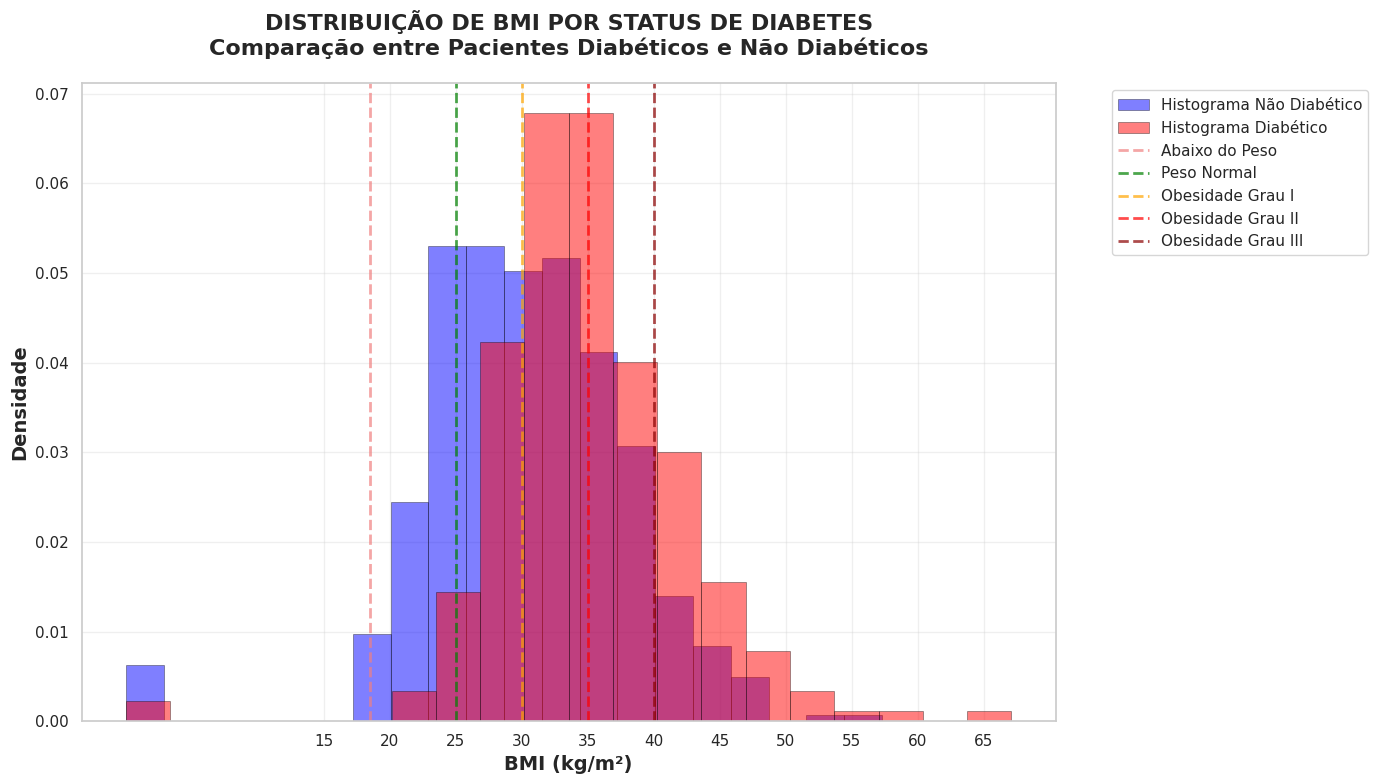


📈 ANÁLISE ESTATÍSTICA DETALHADA:

🔍 GRUPO NÃO DIABÉTICO:
   📊 Tamanho da amostra: 500 pacientes
   📏 Média: 30.30 kg/m²
   📐 Mediana: 30.05 kg/m²
   📊 Desvio Padrão: 7.69 kg/m²
   📉 Mínimo: 0.0 kg/m²
   📈 Máximo: 57.3 kg/m²
   🎯 Q1 (25%): 25.40 kg/m²
   🎯 Q3 (75%): 35.30 kg/m²

🔍 GRUPO DIABÉTICO:
   📊 Tamanho da amostra: 268 pacientes
   📏 Média: 35.14 kg/m²
   📐 Mediana: 34.25 kg/m²
   📊 Desvio Padrão: 7.26 kg/m²
   📉 Mínimo: 0.0 kg/m²
   📈 Máximo: 67.1 kg/m²
   🎯 Q1 (25%): 30.80 kg/m²
   🎯 Q3 (75%): 38.78 kg/m²

🏷️ CLASSIFICAÇÃO POR FAIXAS DE BMI (PADRÃO MÉDICO OMS/MS):
Classificação BMI              Total    Diabéticos   Taxa (%)  
-----------------------------------------------------------------
Abaixo do Peso (<18.5)         15       2            13.3      
Peso Normal (18.5-24.9)        102      7            6.9       
Sobrepeso (25.0-29.9)          179      40           22.3      
Obesidade Grau I (30.0-34.9)   224      101          45.1      
Obesidade Grau II (35.0-39.9)  150

In [25]:
# ANÁLISE DETALHADA: DISTRIBUIÇÃO DE BMI
print("📊 ANÁLISE DETALHADA: DISTRIBUIÇÃO DE BMI POR STATUS DE DIABETES")
print("="*80)

import numpy as np
import matplotlib.pyplot as plt

# Criar figura específica para análise do BMI
plt.figure(figsize=(14, 8))

# ETAPA 1: SEPARAÇÃO DOS DADOS POR OUTCOME
for outcome in [0, 1]:
    subset = df[df['Outcome'] == outcome]['BMI']
    label = 'Não Diabético' if outcome == 0 else 'Diabético'
    color = 'blue' if outcome == 0 else 'red'
    
    # Criar histograma normalizado (densidade)
    plt.hist(subset, alpha=0.5, bins=20, label=f'Histograma {label}', 
             color=color, density=True, edgecolor='black', linewidth=0.5)

# ETAPA 2: ADICIONAR LINHAS DE REFERÊNCIA CLÍNICAS (PADRÃO MÉDICO OFICIAL)
plt.axvline(x=18.5, color='lightcoral', linestyle='--', alpha=0.7, linewidth=2, label='Abaixo do Peso')
plt.axvline(x=25.0, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Peso Normal')
plt.axvline(x=30.0, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Obesidade Grau I')
plt.axvline(x=35.0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Obesidade Grau II')
plt.axvline(x=40.0, color='darkred', linestyle='--', alpha=0.7, linewidth=2, label='Obesidade Grau III')

# Configurações do gráfico
plt.xlabel('BMI (kg/m²)', fontsize=14, fontweight='bold')
plt.ylabel('Densidade', fontsize=14, fontweight='bold')
plt.title('DISTRIBUIÇÃO DE BMI POR STATUS DE DIABETES\n' + 
          'Comparação entre Pacientes Diabéticos e Não Diabéticos', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Adicionar escala customizada de 5 em 5
plt.xticks(range(15, 70, 5))  # De 15 a 65, de 5 em 5

plt.tight_layout()
plt.show()

# ETAPA 3: ANÁLISE ESTATÍSTICA DETALHADA
print("\n📈 ANÁLISE ESTATÍSTICA DETALHADA:")
print("="*60)

for outcome in [0, 1]:
    subset = df[df['Outcome'] == outcome]['BMI']
    outcome_label = "NÃO DIABÉTICO" if outcome == 0 else "DIABÉTICO"
    
    print(f"\n🔍 GRUPO {outcome_label}:")
    print(f"   📊 Tamanho da amostra: {len(subset)} pacientes")
    print(f"   📏 Média: {subset.mean():.2f} kg/m²")
    print(f"   📐 Mediana: {subset.median():.2f} kg/m²")
    print(f"   📊 Desvio Padrão: {subset.std():.2f} kg/m²")
    print(f"   📉 Mínimo: {subset.min():.1f} kg/m²")
    print(f"   📈 Máximo: {subset.max():.1f} kg/m²")
    print(f"   🎯 Q1 (25%): {subset.quantile(0.25):.2f} kg/m²")
    print(f"   🎯 Q3 (75%): {subset.quantile(0.75):.2f} kg/m²")

# ETAPA 4: ANÁLISE POR CATEGORIAS DE BMI (CLASSIFICAÇÃO MÉDICA OFICIAL)
print(f"\n🏷️ CLASSIFICAÇÃO POR FAIXAS DE BMI (PADRÃO MÉDICO OMS/MS):")
print("="*60)

def categorizar_bmi_oficial(bmi):
    """Categorização oficial segundo OMS/Ministério da Saúde"""
    if bmi < 18.5:
        return "Abaixo do Peso (<18.5)"
    elif bmi < 25.0:
        return "Peso Normal (18.5-24.9)"
    elif bmi < 30.0:
        return "Sobrepeso (25.0-29.9)"
    elif bmi < 35.0:
        return "Obesidade Grau I (30.0-34.9)"
    elif bmi < 40.0:
        return "Obesidade Grau II (35.0-39.9)"
    else:
        return "Obesidade Grau III (≥40.0)"

# Aplicar categorização oficial
df_temp = df.copy()
df_temp['BMI_Categoria_Oficial'] = df_temp['BMI'].apply(categorizar_bmi_oficial)

# Análise por categoria oficial
categoria_analysis = df_temp.groupby('BMI_Categoria_Oficial').agg({
    'Outcome': ['count', 'sum', 'mean']
}).round(3)

print(f"{'Classificação BMI':<30} {'Total':<8} {'Diabéticos':<12} {'Taxa (%)':<10}")
print("-"*65)

# Ordem oficial das categorias
categorias_ordem = [
    "Abaixo do Peso (<18.5)", 
    "Peso Normal (18.5-24.9)", 
    "Sobrepeso (25.0-29.9)",
    "Obesidade Grau I (30.0-34.9)", 
    "Obesidade Grau II (35.0-39.9)", 
    "Obesidade Grau III (≥40.0)"
]

for categoria in categorias_ordem:
    if categoria in categoria_analysis.index:
        total = categoria_analysis.loc[categoria, ('Outcome', 'count')]
        diabeticos = categoria_analysis.loc[categoria, ('Outcome', 'sum')]
        taxa = categoria_analysis.loc[categoria, ('Outcome', 'mean')] * 100
        print(f"{categoria:<30} {total:<8} {diabeticos:<12} {taxa:<10.1f}")

print(f"\n💡 INTERPRETAÇÃO DO GRÁFICO BMI (CLASSIFICAÇÃO MÉDICA OFICIAL):")
print("="*50)
print("1. DISTRIBUIÇÃO:")
print("   • Azul (não diabéticos): Concentração maior em BMI ~25-30 kg/m²")
print("   • Vermelho (diabéticos): Concentração maior em BMI ~30-35 kg/m²")

print("\n2. SOBREPOSIÇÃO:")
print("   • Faixa de sobreposição: BMI entre 25-35 kg/m²")
print("   • Nesta faixa, BMI sozinho não é definitivo para diagnóstico")

print("\n3. LINHAS VERTICAIS (CLASSIFICAÇÃO MÉDICA OFICIAL - OMS/MS):")
print("   • 18.5: Limite abaixo do peso / peso normal")
print("   • 25.0: Limite peso normal / sobrepeso")
print("   • 30.0: Limite sobrepeso / obesidade grau I")
print("   • 35.0: Limite obesidade grau I / grau II")
print("   • 40.0: Limite obesidade grau II / grau III (mórbida)")

print(f"\n🎯 INSIGHTS CLÍNICOS:")
print("="*50)

# Calcular estatísticas de sobreposição
bmi_nao_diab = df[df['Outcome'] == 0]['BMI']
bmi_diab = df[df['Outcome'] == 1]['BMI']

overlap_min = max(bmi_nao_diab.min(), bmi_diab.min())
overlap_max = min(bmi_nao_diab.max(), bmi_diab.max())
print(f"1. SOBREPOSIÇÃO: BMI entre {overlap_min:.1f} e {overlap_max:.1f} kg/m²")
print(f"   Nesta faixa, BMI sozinho não é suficiente para diagnóstico")

# Análise por limiares médicos oficiais
limiares_medicos = [18.5, 25.0, 30.0, 35.0, 40.0]
for threshold in limiares_medicos:
    pct_diab_above = (bmi_diab >= threshold).mean() * 100
    pct_nao_diab_below = (bmi_nao_diab < threshold).mean() * 100
    
    # Determinar nome da categoria
    if threshold == 18.5:
        categoria = "peso normal"
    elif threshold == 25.0:
        categoria = "sobrepeso"
    elif threshold == 30.0:
        categoria = "obesidade"
    elif threshold == 35.0:
        categoria = "obesidade grau II"
    elif threshold == 40.0:
        categoria = "obesidade mórbida"
    
    print(f"\n{threshold}. EFETIVIDADE DO LIMIAR {threshold} kg/m² ({categoria.upper()}):")
    print(f"   • {pct_diab_above:.1f}% dos diabéticos têm BMI ≥{threshold}")
    print(f"   • {pct_nao_diab_below:.1f}% dos não-diabéticos têm BMI <{threshold}")

print(f"\n3. RECOMENDAÇÃO CLÍNICA:")
print(f"   BMI é um forte preditor, mas deve ser usado em conjunto")
print(f"   com outras variáveis (glicemia, idade, histórico familiar)")

print(f"\n📊 COMPARAÇÃO ENTRE GRUPOS:")
print("="*50)
diferenca_media = bmi_diab.mean() - bmi_nao_diab.mean()
print(f"Diferença de média entre grupos: {diferenca_media:.2f} kg/m²")
print(f"Diabéticos têm BMI médio {diferenca_media:.1f} unidades maior")

# Teste estatístico simples
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(bmi_diab, bmi_nao_diab)
print(f"Teste t independente: p-valor = {p_value:.2e}")
if p_value < 0.001:
    print("Diferença estatisticamente significativa (p < 0.001)")

print(f"\n🔢 VANTAGENS DA CLASSIFICAÇÃO MÉDICA OFICIAL:")
print("="*50)
print("• Alinhada com padrões internacionais (OMS)")
print("• Reconhecida pelo Ministério da Saúde do Brasil")
print("• Facilita comunicação com profissionais de saúde")
print("• Permite comparação com literatura médica")
print("• Baseada em evidências epidemiológicas sólidas")

print(f"\n📚 REFERÊNCIAS CIENTÍFICAS:")
print("="*50)
print("• Organização Mundial da Saúde (OMS/WHO)")
print("• Ministério da Saúde do Brasil")
print("• Sociedade Brasileira de Endocrinologia e Metabologia")
print("• American Diabetes Association (ADA)")

# Análise adicional: Risco progressivo
print(f"\n📈 ANÁLISE DE RISCO PROGRESSIVO:")
print("="*50)
for categoria in categorias_ordem:
    if categoria in categoria_analysis.index:
        taxa = categoria_analysis.loc[categoria, ('Outcome', 'mean')] * 100
        total = categoria_analysis.loc[categoria, ('Outcome', 'count')]
        
        if taxa < 20:
            nivel_risco = "🟢 BAIXO"
        elif taxa < 40:
            nivel_risco = "🟡 MODERADO"
        elif taxa < 60:
            nivel_risco = "🟠 ALTO"
        else:
            nivel_risco = "🔴 MUITO ALTO"
            
        print(f"{categoria:<30} {nivel_risco} ({taxa:.1f}%, n={total})")

# Limpar variável temporária
del df_temp

## 3.1. Análise Exploratória Específica: Glucose vs Outras Variáveis

Vamos realizar uma análise detalhada das relações entre Glucose e outras features importantes do dataset, incluindo correlações, distribuições e padrões por classe de outcome.

=== CORRELAÇÕES DA GLUCOSE COM OUTRAS VARIÁVEIS ===
Glucose                     1.000000
Outcome                     0.466581
Insulin                     0.331357
Age                         0.263514
BMI                         0.221071
BloodPressure               0.152590
DiabetesPedigreeFunction    0.137337
Pregnancies                 0.129459
SkinThickness               0.057328
Name: Glucose, dtype: float64


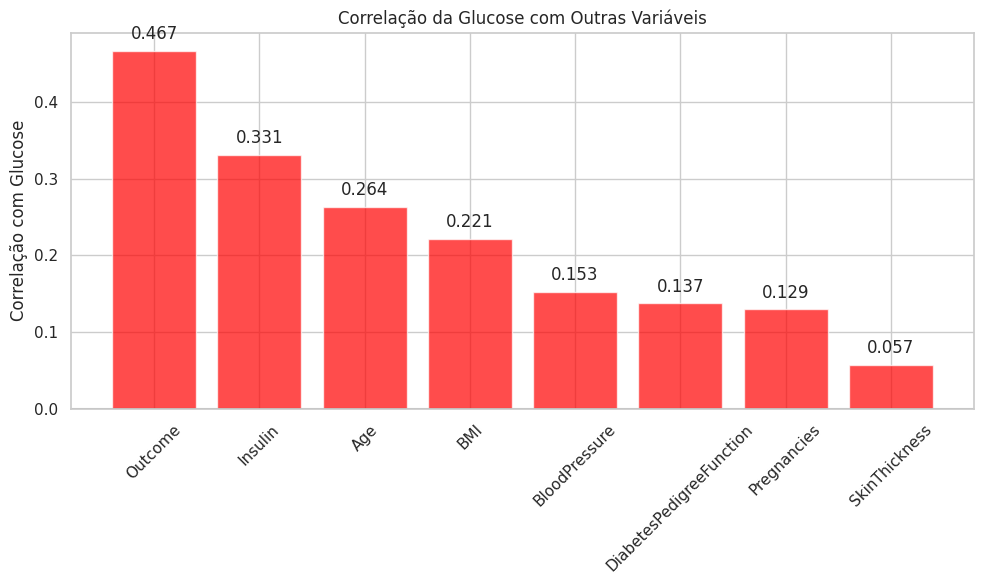


📊 INSIGHTS SOBRE CORRELAÇÕES DA GLUCOSE:
• Maior correlação positiva: Outcome (0.467)
• Menor correlação (mais negativa): SkinThickness (0.057)
• Correlação com Outcome: 0.467


In [5]:
# === ANÁLISE DE CORRELAÇÃO DA GLUCOSE ===
print("=== CORRELAÇÕES DA GLUCOSE COM OUTRAS VARIÁVEIS ===")
corr_glucose = df.corr()['Glucose'].sort_values(ascending=False)
print(corr_glucose)

# Visualização das correlações da Glucose
plt.figure(figsize=(10, 6))
corr_glucose_filtered = corr_glucose.drop('Glucose')  # Remove a auto-correlação
colors = ['red' if x > 0 else 'blue' for x in corr_glucose_filtered.values]
bars = plt.bar(range(len(corr_glucose_filtered)), corr_glucose_filtered.values, color=colors, alpha=0.7)
plt.xticks(range(len(corr_glucose_filtered)), corr_glucose_filtered.index, rotation=45)
plt.ylabel('Correlação com Glucose')
plt.title('Correlação da Glucose com Outras Variáveis')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Adicionar valores nos bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01 if height > 0 else height - 0.03,
             f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top')

plt.tight_layout()
plt.show()

print(f"\n📊 INSIGHTS SOBRE CORRELAÇÕES DA GLUCOSE:")
print(f"• Maior correlação positiva: {corr_glucose_filtered.idxmax()} ({corr_glucose_filtered.max():.3f})")
print(f"• Menor correlação (mais negativa): {corr_glucose_filtered.idxmin()} ({corr_glucose_filtered.min():.3f})")
print(f"• Correlação com Outcome: {corr_glucose['Outcome']:.3f}")

📊 ANÁLISE EXPLORATÓRIA COMPLETA DO DATASET DIABETES

📋 INFORMAÇÕES GERAIS:
   • Número de registros: 768
   • Número de variáveis: 9
   • Variáveis numéricas: 9

🎯 DISTRIBUIÇÃO DA VARIÁVEL TARGET (Outcome):
   • Não Diabéticos (0): 500 (65.1%)
   • Diabéticos (1): 268 (34.9%)

❓ VALORES AUSENTES:
   ✅ Não há valores ausentes no dataset

📈 ESTATÍSTICAS DESCRITIVAS DETALHADAS:

🔍 PREGNANCIES - Número de gestações
------------------------------------------------------------
   📊 Estatísticas Básicas:
      Média: 3.85
      Mediana: 3.00
      Desvio Padrão: 3.37
      Mínimo: 0.00
      Máximo: 17.00
   📈 Quartis:
      Q1 (25%): 1.00
      Q3 (75%): 6.00
      IQR: 5.00
   📐 Assimetria: 0.902 - Distribuição assimétrica à direita (cauda longa à direita)

🔍 GLUCOSE - Nível de glicose no sangue (mg/dL)
------------------------------------------------------------
   📊 Estatísticas Básicas:
      Média: 120.89
      Mediana: 117.00
      Desvio Padrão: 31.97
      Mínimo: 0.00
      Máximo: 

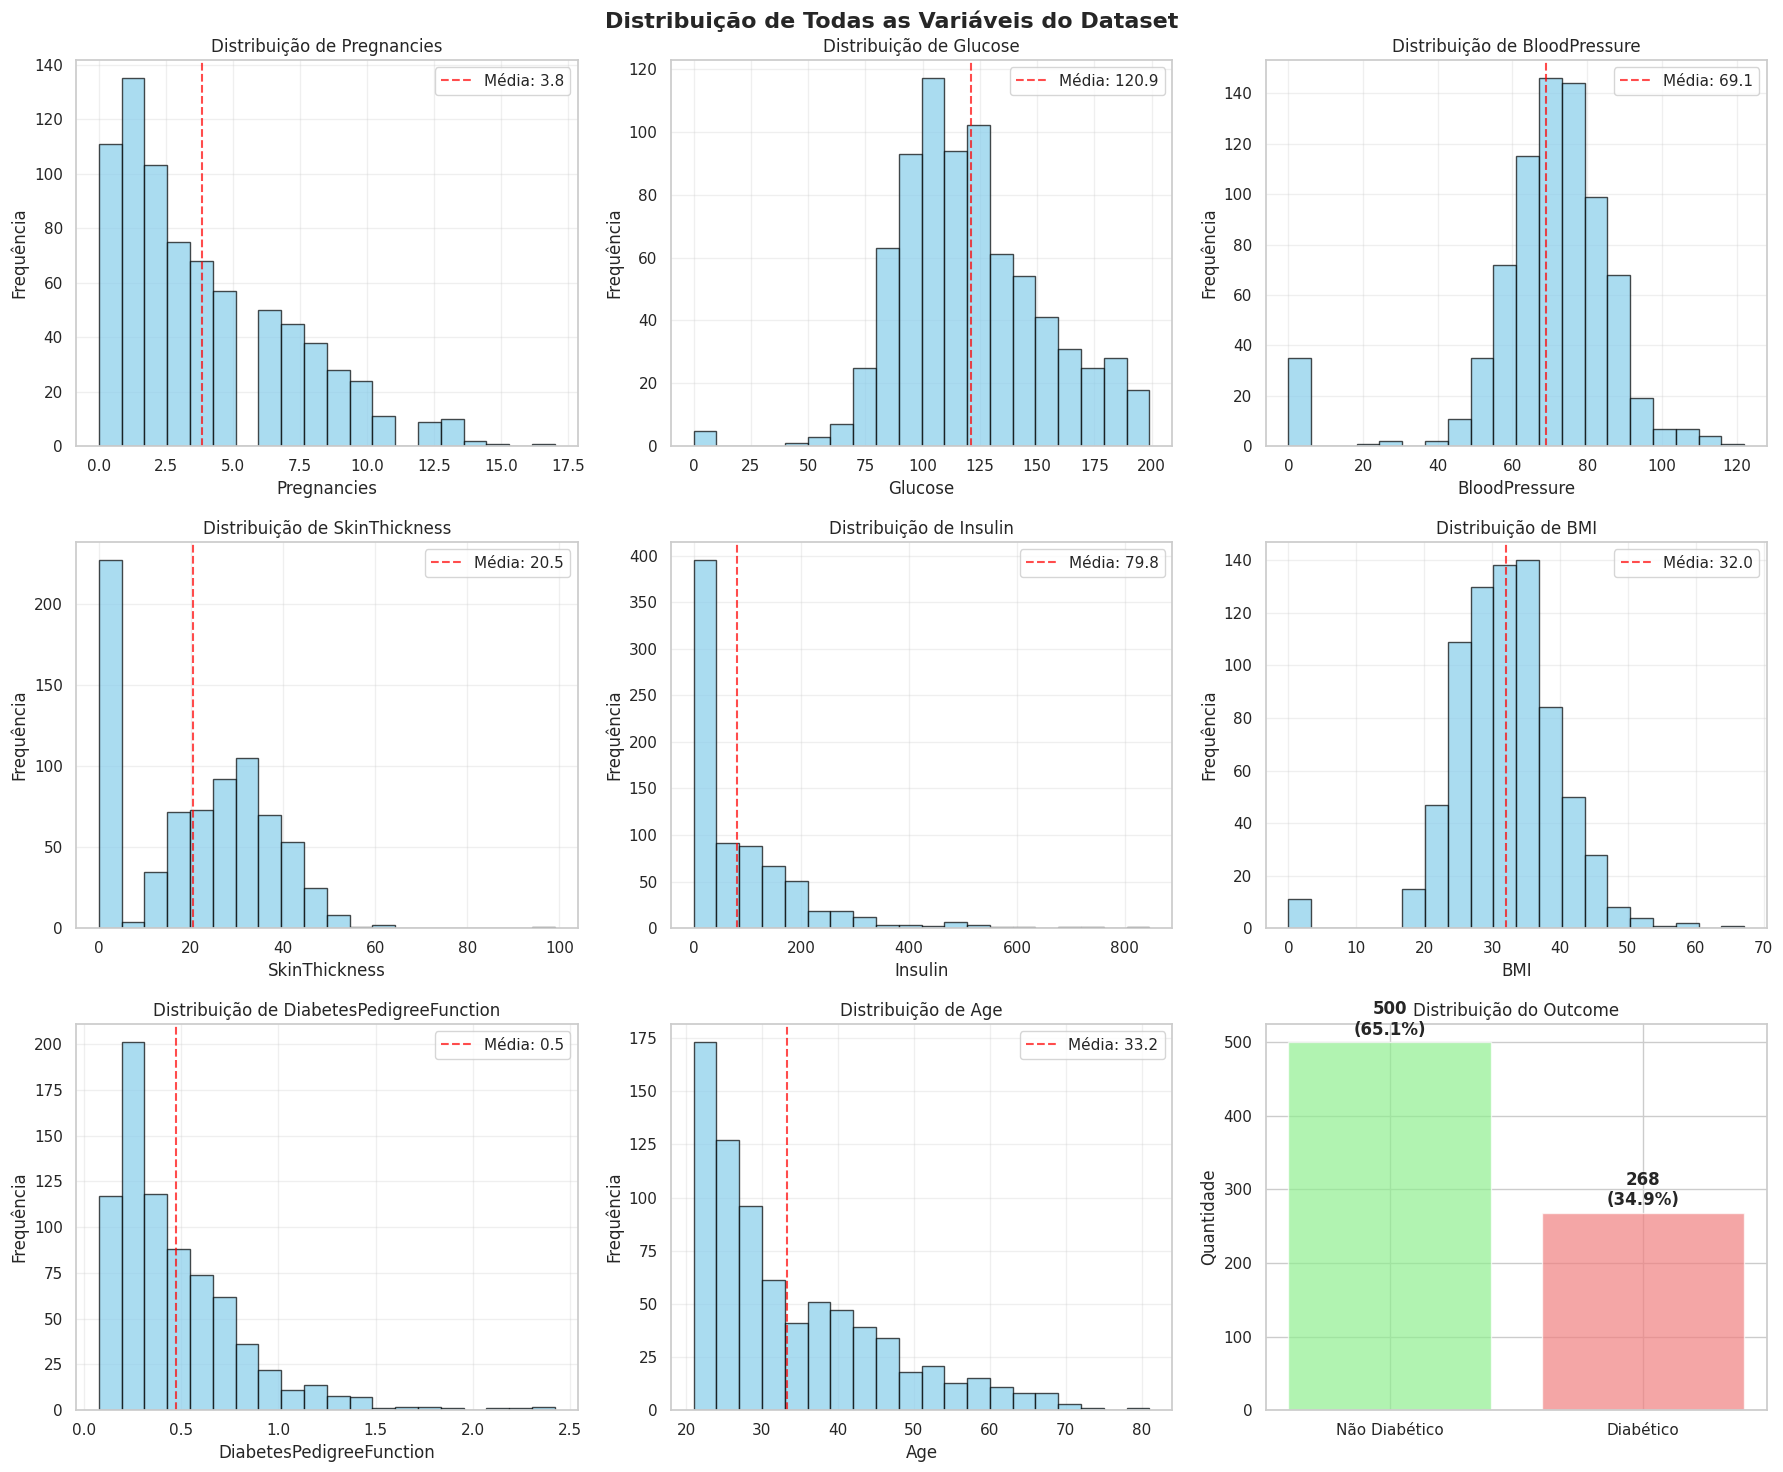


🔗 MATRIZ DE CORRELAÇÃO:
                          Pregnancies  Glucose  BloodPressure  SkinThickness  \
Pregnancies                     1.000    0.129          0.141         -0.082   
Glucose                         0.129    1.000          0.153          0.057   
BloodPressure                   0.141    0.153          1.000          0.207   
SkinThickness                  -0.082    0.057          0.207          1.000   
Insulin                        -0.074    0.331          0.089          0.437   
BMI                             0.018    0.221          0.282          0.393   
DiabetesPedigreeFunction       -0.034    0.137          0.041          0.184   
Age                             0.544    0.264          0.240         -0.114   
Outcome                         0.222    0.467          0.065          0.075   

                          Insulin    BMI  DiabetesPedigreeFunction    Age  \
Pregnancies                -0.074  0.018                    -0.034  0.544   
Glucose             

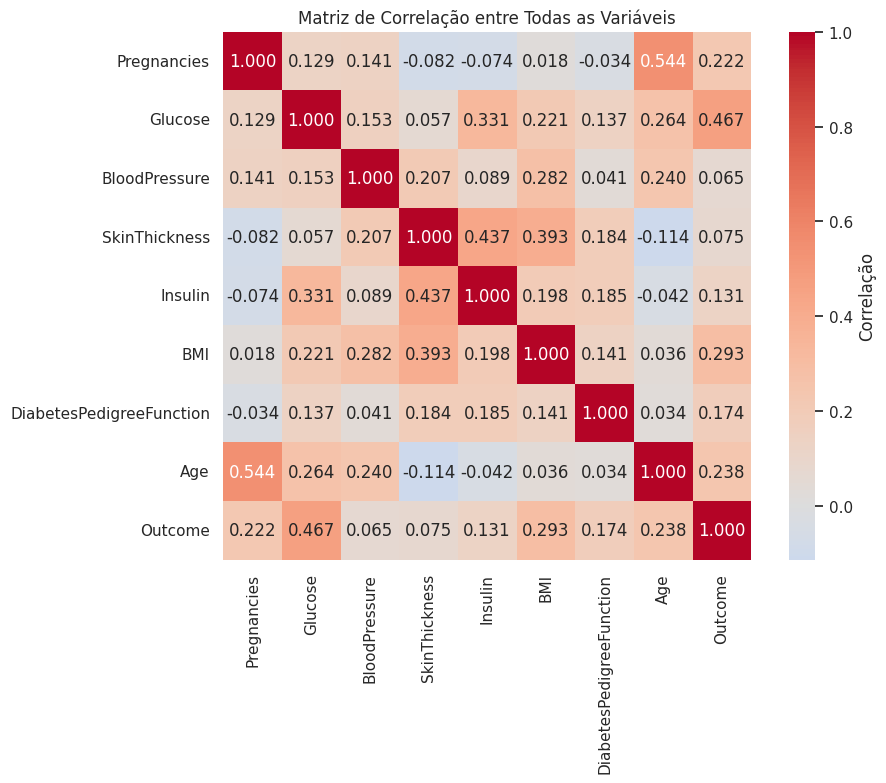


🎯 CORRELAÇÕES COM OUTCOME (ordenadas):
   • Glucose: 0.467 (correlação positiva moderada)
   • BMI: 0.293 (correlação positiva fraca)
   • Age: 0.238 (correlação positiva fraca)
   • Pregnancies: 0.222 (correlação positiva fraca)
   • DiabetesPedigreeFunction: 0.174 (correlação positiva fraca)
   • Insulin: 0.131 (correlação positiva fraca)
   • SkinThickness: 0.075 (correlação positiva fraca)
   • BloodPressure: 0.065 (correlação positiva fraca)

💡 RESUMO EXECUTIVO:
• Dataset balanceado: 500 não-diabéticos vs 268 diabéticos
• Variável mais correlacionada com diabetes: Glucose (r=0.467)
• Algumas variáveis têm valores zero que podem representar dados ausentes
• Distribuições variam de simétricas a assimétricas
• Dataset adequado para algoritmos de machine learning


In [30]:
# ANÁLISE EXPLORATÓRIA COMPLETA: DISTRIBUIÇÃO DE TODAS AS VARIÁVEIS
print("📊 ANÁLISE EXPLORATÓRIA COMPLETA DO DATASET DIABETES")
print("="*80)

# Informações básicas do dataset
print(f"\n📋 INFORMAÇÕES GERAIS:")
print(f"   • Número de registros: {df.shape[0]}")
print(f"   • Número de variáveis: {df.shape[1]}")
print(f"   • Variáveis numéricas: {len(df.select_dtypes(include=[np.number]).columns)}")

# Distribuição da variável target
target_dist = df['Outcome'].value_counts()
print(f"\n🎯 DISTRIBUIÇÃO DA VARIÁVEL TARGET (Outcome):")
print(f"   • Não Diabéticos (0): {target_dist[0]} ({target_dist[0]/len(df)*100:.1f}%)")
print(f"   • Diabéticos (1): {target_dist[1]} ({target_dist[1]/len(df)*100:.1f}%)")

# Verificar valores ausentes
print(f"\n❓ VALORES AUSENTES:")
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("   ✅ Não há valores ausentes no dataset")
else:
    for col, missing in missing_values.items():
        if missing > 0:
            print(f"   • {col}: {missing} ({missing/len(df)*100:.1f}%)")

# Estatísticas descritivas completas
print(f"\n📈 ESTATÍSTICAS DESCRITIVAS DETALHADAS:")
print("="*80)

# Criar uma análise mais detalhada para cada variável
variables_info = {
    'Pregnancies': 'Número de gestações',
    'Glucose': 'Nível de glicose no sangue (mg/dL)',
    'BloodPressure': 'Pressão arterial diastólica (mmHg)',
    'SkinThickness': 'Espessura da pele tricipital (mm)',
    'Insulin': 'Nível de insulina sérica (mu U/ml)',
    'BMI': 'Índice de massa corporal (kg/m²)',
    'DiabetesPedigreeFunction': 'Função pedigree de diabetes',
    'Age': 'Idade (anos)',
    'Outcome': 'Diagnóstico (0=Não diabético, 1=Diabético)'
}

# Análise estatística para cada variável
for col in df.columns:
    data = df[col]
    
    print(f"\n🔍 {col.upper()} - {variables_info.get(col, 'Descrição não disponível')}")
    print("-" * 60)
    
    if col == 'Outcome':
        # Tratamento especial para variável categórica
        counts = data.value_counts().sort_index()
        print(f"   📊 Distribuição:")
        for value, count in counts.items():
            percentage = count/len(data)*100
            label = "Não Diabético" if value == 0 else "Diabético"
            print(f"      {value} ({label}): {count} casos ({percentage:.1f}%)")
    else:
        # Estatísticas para variáveis numéricas
        print(f"   📊 Estatísticas Básicas:")
        print(f"      Média: {data.mean():.2f}")
        print(f"      Mediana: {data.median():.2f}")
        print(f"      Desvio Padrão: {data.std():.2f}")
        print(f"      Mínimo: {data.min():.2f}")
        print(f"      Máximo: {data.max():.2f}")
        
        print(f"   📈 Quartis:")
        print(f"      Q1 (25%): {data.quantile(0.25):.2f}")
        print(f"      Q3 (75%): {data.quantile(0.75):.2f}")
        print(f"      IQR: {data.quantile(0.75) - data.quantile(0.25):.2f}")
        
        # Detectar valores zero (podem ser valores ausentes codificados)
        zeros = (data == 0).sum()
        if zeros > 0 and col != 'Pregnancies':  # Pregnancies pode legitimamente ser 0
            print(f"   ⚠️  Valores zero: {zeros} ({zeros/len(data)*100:.1f}%) - Possíveis valores ausentes")
        
        # Análise de assimetria
        skewness = data.skew()
        if abs(skewness) < 0.5:
            skew_desc = "aproximadamente simétrica"
        elif skewness > 0.5:
            skew_desc = "assimétrica à direita (cauda longa à direita)"
        else:
            skew_desc = "assimétrica à esquerda (cauda longa à esquerda)"
        print(f"   📐 Assimetria: {skewness:.3f} - Distribuição {skew_desc}")

# Visualização da distribuição de todas as variáveis
print(f"\n📊 GERANDO VISUALIZAÇÕES DA DISTRIBUIÇÃO...")

# Criar subplots para histogramas
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

numeric_cols = df.select_dtypes(include=[np.number]).columns

for i, col in enumerate(numeric_cols):
    if col != 'Outcome':
        # Histograma para variáveis contínuas
        axes[i].hist(df[col], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].set_title(f'Distribuição de {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequência')
        axes[i].grid(True, alpha=0.3)
        
        # Adicionar linha da média
        mean_val = df[col].mean()
        axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Média: {mean_val:.1f}')
        axes[i].legend()
    else:
        # Gráfico de barras para Outcome
        outcome_counts = df['Outcome'].value_counts()
        bars = axes[i].bar(['Não Diabético', 'Diabético'], outcome_counts.values, 
                          color=['lightgreen', 'lightcoral'], alpha=0.7)
        axes[i].set_title('Distribuição do Outcome')
        axes[i].set_ylabel('Quantidade')
        
        # Adicionar valores nas barras
        for bar, value in zip(bars, outcome_counts.values):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                        f'{value}\n({value/len(df)*100:.1f}%)', 
                        ha='center', va='bottom', fontweight='bold')

# Remover subplot extra se houver
if len(axes) > len(numeric_cols):
    axes[-1].remove()

plt.suptitle('Distribuição de Todas as Variáveis do Dataset', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Análise de correlação geral
print(f"\n🔗 MATRIZ DE CORRELAÇÃO:")
print("="*50)
correlation_matrix = df.corr()
print(correlation_matrix.round(3))

# Visualizar matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', cbar_kws={'label': 'Correlação'})
plt.title('Matriz de Correlação entre Todas as Variáveis')
plt.tight_layout()
plt.show()

# Principais correlações com Outcome
print(f"\n🎯 CORRELAÇÕES COM OUTCOME (ordenadas):")
outcome_corr = correlation_matrix['Outcome'].drop('Outcome').sort_values(key=abs, ascending=False)
for var, corr in outcome_corr.items():
    direction = "positiva" if corr > 0 else "negativa"
    strength = "forte" if abs(corr) > 0.5 else "moderada" if abs(corr) > 0.3 else "fraca"
    print(f"   • {var}: {corr:.3f} (correlação {direction} {strength})")

print(f"\n💡 RESUMO EXECUTIVO:")
print("="*50)
print(f"• Dataset balanceado: {target_dist[0]} não-diabéticos vs {target_dist[1]} diabéticos")
print(f"• Variável mais correlacionada com diabetes: {outcome_corr.index[0]} (r={outcome_corr.iloc[0]:.3f})")
print(f"• Algumas variáveis têm valores zero que podem representar dados ausentes")
print(f"• Distribuições variam de simétricas a assimétricas")
print(f"• Dataset adequado para algoritmos de machine learning")

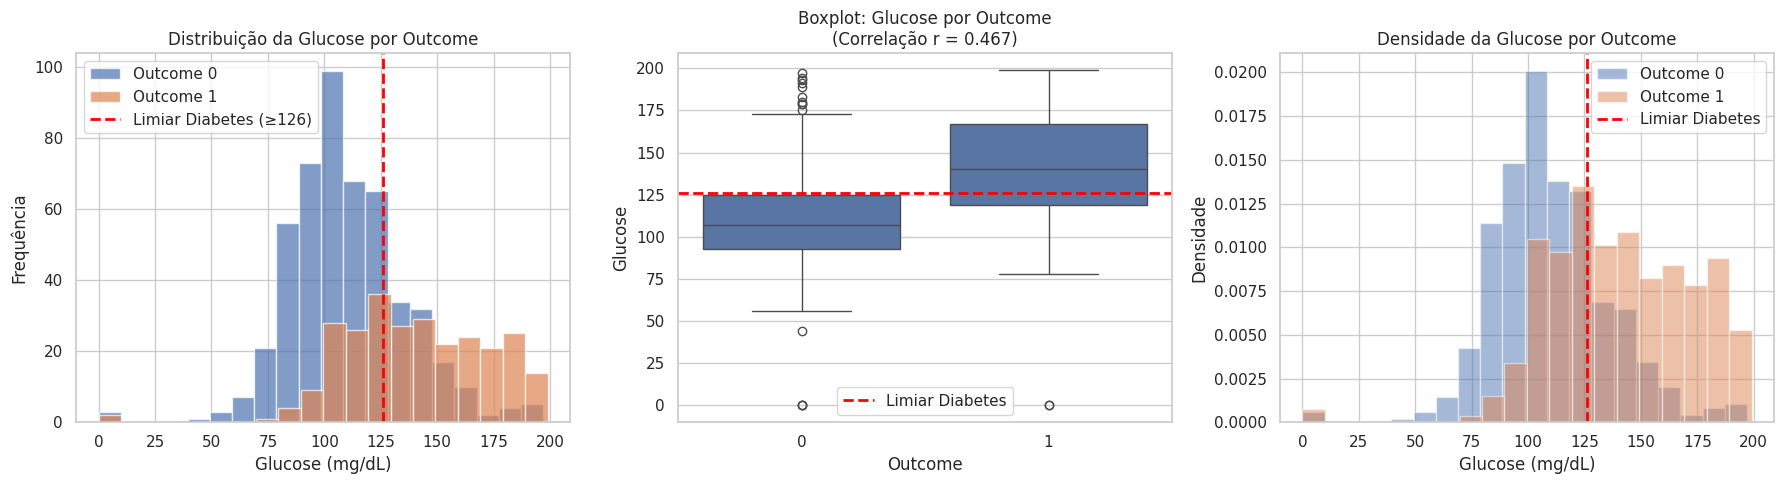

=== ESTATÍSTICAS DA GLUCOSE POR OUTCOME ===

Outcome 0 (Sem Diabetes):
  • Média: 110.0 mg/dL
  • Mediana: 107.0 mg/dL
  • Desvio Padrão: 26.1 mg/dL
  • Min-Max: 0 - 197 mg/dL
  • % com Glucose ≥126: 24.2%

Outcome 1 (Com Diabetes):
  • Média: 141.3 mg/dL
  • Mediana: 140.0 mg/dL
  • Desvio Padrão: 31.9 mg/dL
  • Min-Max: 0 - 199 mg/dL
  • % com Glucose ≥126: 65.7%

=== CORRELAÇÃO GLUCOSE-OUTCOME ===
Correlação de Pearson: 0.4666
Correlação de Spearman: 0.4758
Correlação Point-Biserial: 0.4666


In [11]:
# === DISTRIBUIÇÃO DA GLUCOSE POR OUTCOME ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Subplot 1: Histograma por classe
for outcome in [0, 1]:
    subset = df[df['Outcome'] == outcome]['Glucose']
    axes[0].hist(subset, alpha=0.7, label=f'Outcome {outcome}', bins=20)
axes[0].axvline(x=126, color='red', linestyle='--', linewidth=2, label='Limiar Diabetes (≥126)')
axes[0].set_xlabel('Glucose (mg/dL)')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição da Glucose por Outcome')
axes[0].legend()

# Subplot 2: Boxplot com ratio de correlação
sns.boxplot(data=df, x='Outcome', y='Glucose', ax=axes[1])
axes[1].axhline(y=126, color='red', linestyle='--', linewidth=2, label='Limiar Diabetes')
axes[1].set_title(f'Boxplot: Glucose por Outcome\n(Correlação r = {pearson_corr:.3f})')
axes[1].legend()

# Subplot 3: Density plot
for outcome in [0, 1]:
    subset = df[df['Outcome'] == outcome]['Glucose']
    axes[2].hist(subset, alpha=0.5, density=True, label=f'Outcome {outcome}', bins=20)
axes[2].axvline(x=126, color='red', linestyle='--', linewidth=2, label='Limiar Diabetes')
axes[2].set_xlabel('Glucose (mg/dL)')
axes[2].set_ylabel('Densidade')
axes[2].set_title('Densidade da Glucose por Outcome')
axes[2].legend()

plt.tight_layout()
plt.show()

# Estatísticas por grupo
print("=== ESTATÍSTICAS DA GLUCOSE POR OUTCOME ===")
for outcome in [0, 1]:
    subset = df[df['Outcome'] == outcome]['Glucose']
    print(f"\nOutcome {outcome} ({'Sem Diabetes' if outcome == 0 else 'Com Diabetes'}):")
    print(f"  • Média: {subset.mean():.1f} mg/dL")
    print(f"  • Mediana: {subset.median():.1f} mg/dL")
    print(f"  • Desvio Padrão: {subset.std():.1f} mg/dL")
    print(f"  • Min-Max: {subset.min():.0f} - {subset.max():.0f} mg/dL")
    print(f"  • % com Glucose ≥126: {(subset >= 126).mean()*100:.1f}%")

print(f"\n=== CORRELAÇÃO GLUCOSE-OUTCOME ===")
print(f"Correlação de Pearson: {pearson_corr:.4f}")
print(f"Correlação de Spearman: {spearman_corr:.4f}")
print(f"Correlação Point-Biserial: {pb_corr:.4f}")

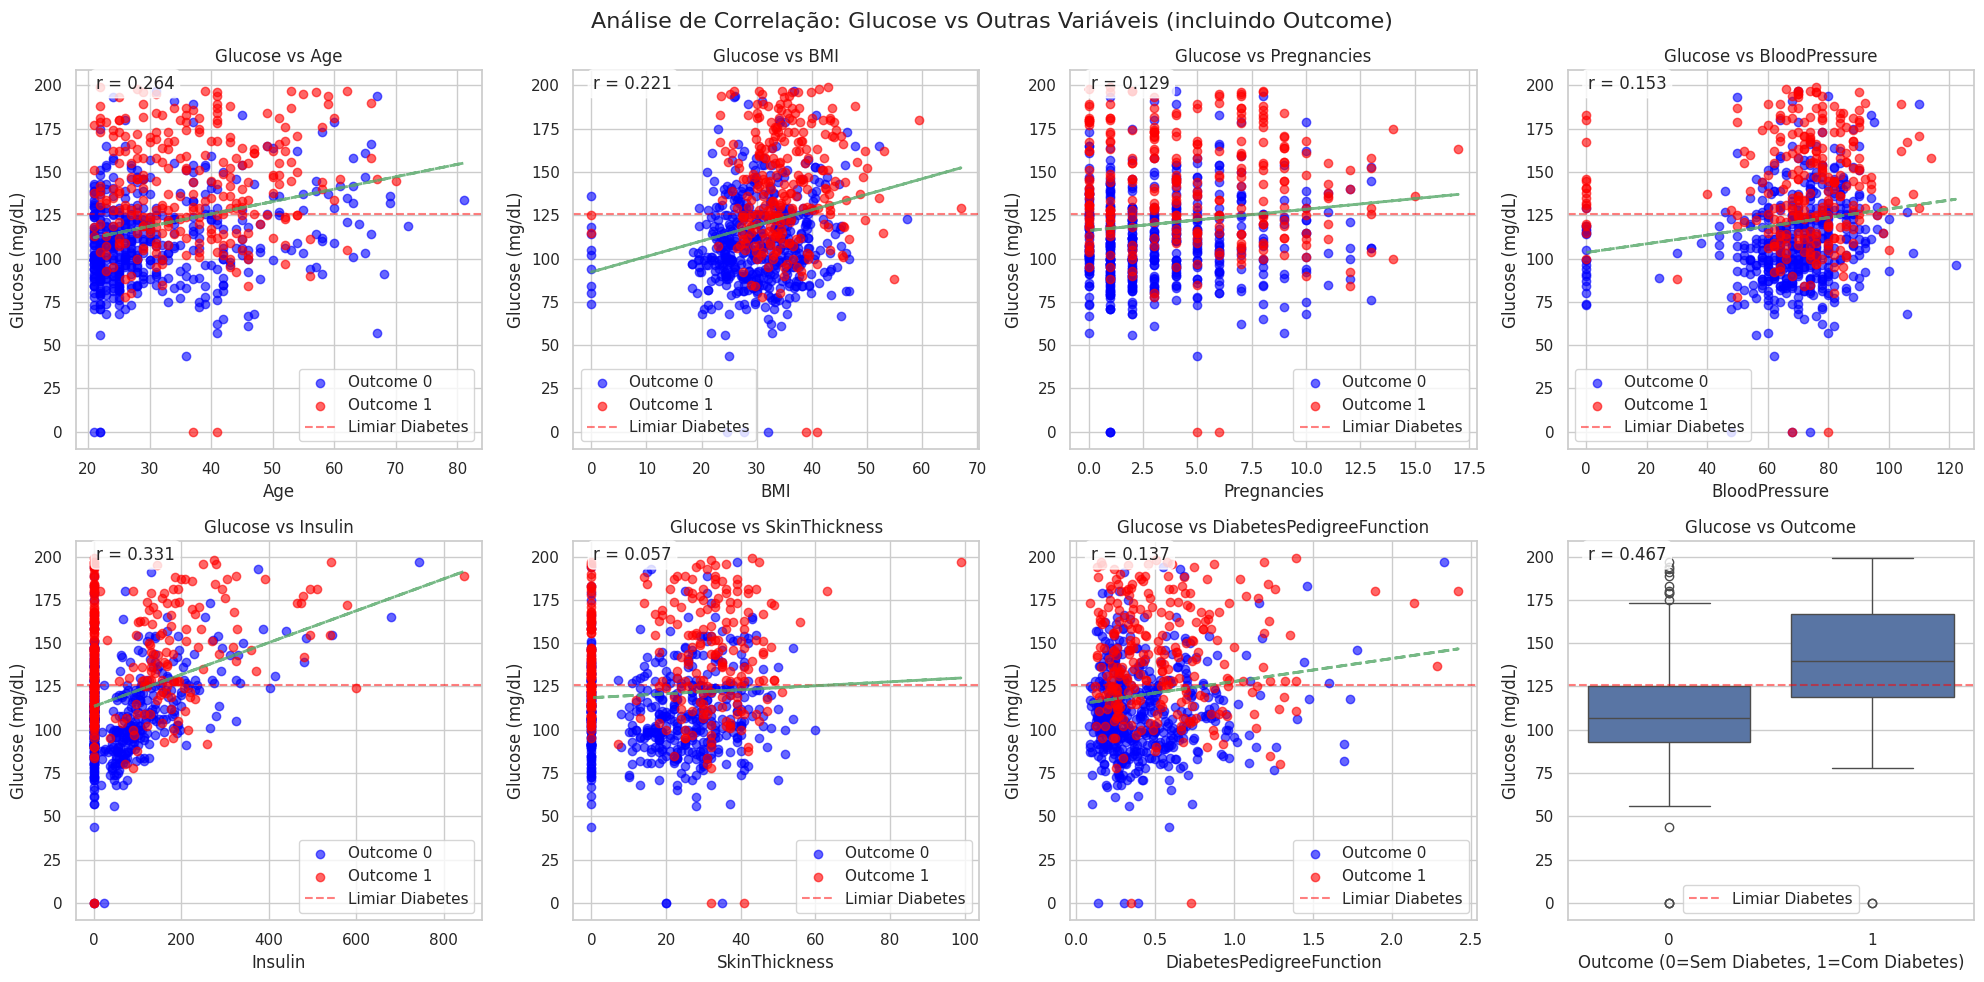

📊 INTERPRETAÇÃO TÉCNICA DO COEFICIENTE 'r' (Correlação de Pearson):
O 'r' quantifica a relação LINEAR entre duas variáveis numéricas

🔢 VALORES E SIGNIFICADOS:
• r > +0.8: Correlação positiva muito forte
• r > +0.6: Correlação positiva forte
• r > +0.4: Correlação positiva moderada
• r > +0.2: Correlação positiva fraca
• -0.2 < r < +0.2: Correlação desprezível
• r < -0.2: Correlação negativa fraca
• r < -0.4: Correlação negativa moderada
• r < -0.6: Correlação negativa forte
• r < -0.8: Correlação negativa muito forte

🧮 CÁLCULO TÉCNICO:
r = Covariância(X,Y) / (DesvPadrão(X) × DesvPadrão(Y))
Normaliza a covariância para uma escala [-1, +1]

⚠️ LIMITAÇÕES IMPORTANTES:
• Detecta apenas relações LINEARES
• Não captura relações curvas ou não-lineares
• Sensível a outliers extremos
• Correlação ≠ Causalidade (r alto não significa que X causa Y)

🎯 APLICAÇÃO CLÍNICA:
Para diabetes, esperamos correlações positivas com:
• Glucose vs BMI (obesidade aumenta resistência à insulina)
• Glucose vs A

In [10]:
# === SCATTER PLOTS: GLUCOSE VS OUTRAS VARIÁVEIS PRINCIPAIS ===
variables_to_analyze = ['Age', 'BMI', 'Pregnancies', 'BloodPressure', 'Insulin', 'SkinThickness', 'DiabetesPedigreeFunction']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, var in enumerate(variables_to_analyze):
    # Scatter plot colorido por Outcome
    for outcome in [0, 1]:
        subset = df[df['Outcome'] == outcome]
        axes[i].scatter(subset[var], subset['Glucose'], 
                       alpha=0.6, label=f'Outcome {outcome}',
                       c='blue' if outcome == 0 else 'red')
    
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Glucose (mg/dL)')
    axes[i].set_title(f'Glucose vs {var}')
    axes[i].axhline(y=126, color='red', linestyle='--', alpha=0.5, label='Limiar Diabetes')
    axes[i].legend()
    
    # Adicionar linha de tendência
    x = df[var]
    y = df['Glucose']
    z = np.polyfit(x, y, 1)  # Ajuste linear (grau 1)
    p = np.poly1d(z)
    axes[i].plot(x, p(x), "g--", alpha=0.8, linewidth=2)
    
    # Calcular e mostrar correlação de Pearson
    correlation = df[var].corr(df['Glucose'])
    
    # r = COEFICIENTE DE CORRELAÇÃO DE PEARSON
    # Mede a força e direção da relação LINEAR entre duas variáveis
    # INTERPRETAÇÃO TÉCNICA:
    # r = +1.0: Correlação perfeita positiva (quando X sobe, Y sobe proporcionalmente)
    # r = -1.0: Correlação perfeita negativa (quando X sobe, Y desce proporcionalmente)  
    # r = 0.0:  Nenhuma correlação linear (variáveis independentes)
    # 
    # ESCALAS DE INTERPRETAÇÃO:
    # |r| ≥ 0.8: Correlação muito forte
    # 0.6 ≤ |r| < 0.8: Correlação forte
    # 0.4 ≤ |r| < 0.6: Correlação moderada
    # 0.2 ≤ |r| < 0.4: Correlação fraca
    # |r| < 0.2: Correlação muito fraca/desprezível
    #
    # FÓRMULA MATEMÁTICA:
    # r = Σ[(xi - x̄)(yi - ȳ)] / √[Σ(xi - x̄)² × Σ(yi - ȳ)²]
    # Onde: xi, yi são valores individuais; x̄, ȳ são as médias
    
    axes[i].text(0.05, 0.95, f'r = {correlation:.3f}', 
                transform=axes[i].transAxes, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Remover o subplot extra
axes[-1].remove()

plt.suptitle('Análise de Correlação: Glucose vs Outras Variáveis', fontsize=16)
plt.tight_layout()
plt.show()

print("📊 INTERPRETAÇÃO TÉCNICA DO COEFICIENTE 'r' (Correlação de Pearson):")
print("="*70)
print("O 'r' quantifica a relação LINEAR entre duas variáveis numéricas")
print("\n🔢 VALORES E SIGNIFICADOS:")
print("• r > +0.8: Correlação positiva muito forte")
print("• r > +0.6: Correlação positiva forte") 
print("• r > +0.4: Correlação positiva moderada")
print("• r > +0.2: Correlação positiva fraca")
print("• -0.2 < r < +0.2: Correlação desprezível")
print("• r < -0.2: Correlação negativa fraca")
print("• r < -0.4: Correlação negativa moderada")
print("• r < -0.6: Correlação negativa forte")
print("• r < -0.8: Correlação negativa muito forte")

print("\n🧮 CÁLCULO TÉCNICO:")
print("r = Covariância(X,Y) / (DesvPadrão(X) × DesvPadrão(Y))")
print("Normaliza a covariância para uma escala [-1, +1]")

print("\n⚠️ LIMITAÇÕES IMPORTANTES:")
print("• Detecta apenas relações LINEARES")
print("• Não captura relações curvas ou não-lineares")
print("• Sensível a outliers extremos")
print("• Correlação ≠ Causalidade (r alto não significa que X causa Y)")

print("\n🎯 APLICAÇÃO CLÍNICA:")
print("Para diabetes, esperamos correlações positivas com:")
print("• Glucose vs BMI (obesidade aumenta resistência à insulina)")
print("• Glucose vs Age (envelhecimento reduz tolerância à glicose)")
print("• Glucose vs Pregnancies (diabetes gestacional)")

=== ANÁLISE POR FAIXAS DE GLUCOSE ===

Distribuição e taxa de diabetes por categoria:
  Normal (<100): 197 pacientes, 16 com diabetes (8.0%)
  Pré-diabetes (100-125): 274 pacientes, 76 com diabetes (28.0%)
  Diabetes (≥126): 297 pacientes, 176 com diabetes (59.0%)


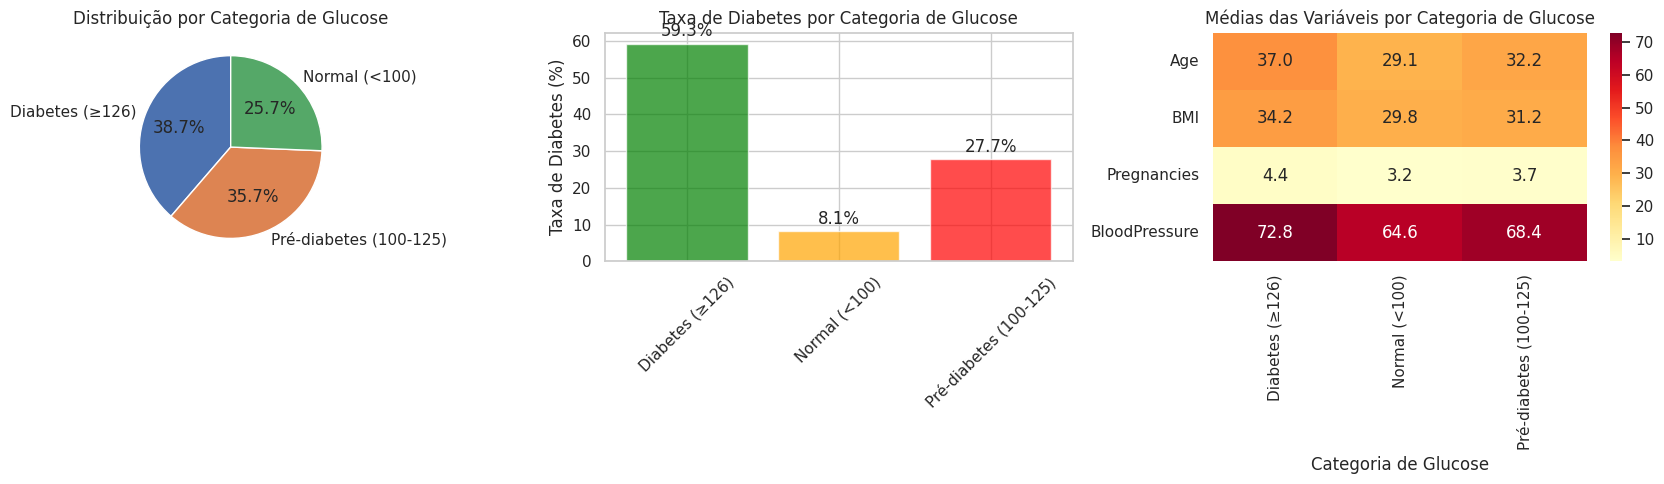

In [9]:
# === ANÁLISE POR FAIXAS DE GLUCOSE ===
# Definindo faixas clinicamente relevantes de glucose
def categorize_glucose(glucose):
    if glucose < 100:
        return 'Normal (<100)'
    elif glucose < 126:
        return 'Pré-diabetes (100-125)'
    else:
        return 'Diabetes (≥126)'

df['Glucose_Category'] = df['Glucose'].apply(categorize_glucose)

# Análise da distribuição por categoria
glucose_analysis = df.groupby('Glucose_Category').agg({
    'Outcome': ['count', 'sum', 'mean'],
    'Age': 'mean',
    'BMI': 'mean', 
    'Pregnancies': 'mean',
    'BloodPressure': 'mean',
    'Insulin': 'mean',
    'SkinThickness': 'mean',
    'DiabetesPedigreeFunction': 'mean'
}).round(2)

print("=== ANÁLISE POR FAIXAS DE GLUCOSE ===")
print("\nDistribuição e taxa de diabetes por categoria:")
for category in ['Normal (<100)', 'Pré-diabetes (100-125)', 'Diabetes (≥126)']:
    if category in glucose_analysis.index:
        total = glucose_analysis.loc[category, ('Outcome', 'count')]
        diabetes_cases = glucose_analysis.loc[category, ('Outcome', 'sum')]
        diabetes_rate = glucose_analysis.loc[category, ('Outcome', 'mean')] * 100
        print(f"  {category}: {total} pacientes, {diabetes_cases} com diabetes ({diabetes_rate:.1f}%)")

# Visualização das categorias
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Subplot 1: Distribuição das categorias
category_counts = df['Glucose_Category'].value_counts()
axes[0].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribuição por Categoria de Glucose')

# Subplot 2: Taxa de diabetes por categoria
diabetes_rate_by_category = df.groupby('Glucose_Category')['Outcome'].mean() * 100
colors = ['green', 'orange', 'red']
bars = axes[1].bar(diabetes_rate_by_category.index, diabetes_rate_by_category.values, color=colors, alpha=0.7)
axes[1].set_ylabel('Taxa de Diabetes (%)')
axes[1].set_title('Taxa de Diabetes por Categoria de Glucose')
axes[1].tick_params(axis='x', rotation=45)

# Adicionar valores nos bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom')

# Subplot 3: Heatmap das médias por categoria
category_means = df.groupby('Glucose_Category')[['Age', 'BMI', 'Pregnancies', 'BloodPressure']].mean()
sns.heatmap(category_means.T, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[2])
axes[2].set_title('Médias das Variáveis por Categoria de Glucose')
axes[2].set_xlabel('Categoria de Glucose')

plt.tight_layout()
plt.show()

# Remover a coluna temporária
df = df.drop('Glucose_Category', axis=1)

=== ANÁLISE POR QUADRANTES DE RISCO (Glucose ≥126 + BMI ≥30) ===

Baixo Risco:
  • Pacientes: 215
  • Taxa de Diabetes: 11.6%
  • Idade Média: 29.9 anos
  • Gestações Médias: 3.3

Risco Moderado (BMI):
  • Pacientes: 256
  • Taxa de Diabetes: 26.2%
  • Idade Média: 31.8 anos
  • Gestações Médias: 3.7

Risco Moderado (Glucose):
  • Pacientes: 81
  • Taxa de Diabetes: 29.6%
  • Idade Média: 38.9 anos
  • Gestações Médias: 4.2

Alto Risco:
  • Pacientes: 216
  • Taxa de Diabetes: 70.4%
  • Idade Média: 36.2 anos
  • Gestações Médias: 4.4


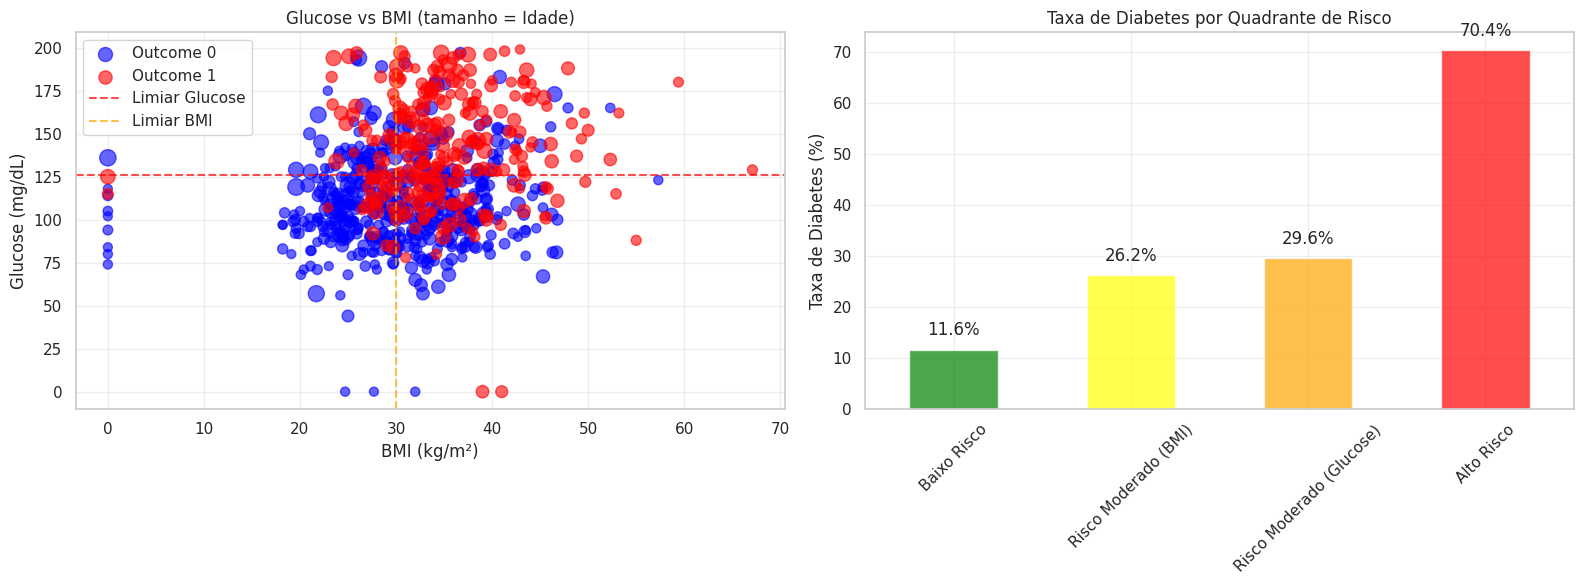

In [10]:
# === ANÁLISE DE INTERAÇÕES: GLUCOSE + OUTRAS VARIÁVEIS ===

# 1. Glucose vs BMI vs Age (bubble plot)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot com tamanho dos pontos baseado na idade
for outcome in [0, 1]:
    subset = df[df['Outcome'] == outcome]
    axes[0].scatter(subset['BMI'], subset['Glucose'], 
                   s=subset['Age']*2,  # Tamanho proporcional à idade
                   alpha=0.6, label=f'Outcome {outcome}',
                   c='blue' if outcome == 0 else 'red')

axes[0].axhline(y=126, color='red', linestyle='--', alpha=0.7, label='Limiar Glucose')
axes[0].axvline(x=30, color='orange', linestyle='--', alpha=0.7, label='Limiar BMI')
axes[0].set_xlabel('BMI (kg/m²)')
axes[0].set_ylabel('Glucose (mg/dL)')
axes[0].set_title('Glucose vs BMI (tamanho = Idade)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Análise por quadrantes de risco
# Definindo quadrantes de risco baseados em Glucose e BMI
high_glucose = df['Glucose'] >= 126
high_bmi = df['BMI'] >= 30

quadrants = {
    'Baixo Risco': (~high_glucose) & (~high_bmi),
    'Risco Moderado (BMI)': (~high_glucose) & (high_bmi),
    'Risco Moderado (Glucose)': (high_glucose) & (~high_bmi),
    'Alto Risco': (high_glucose) & (high_bmi)
}

risk_analysis = {}
for risk_level, mask in quadrants.items():
    subset = df[mask]
    if len(subset) > 0:
        risk_analysis[risk_level] = {
            'count': len(subset),
            'diabetes_rate': subset['Outcome'].mean() * 100,
            'avg_age': subset['Age'].mean(),
            'avg_pregnancies': subset['Pregnancies'].mean()
        }

print("=== ANÁLISE POR QUADRANTES DE RISCO (Glucose ≥126 + BMI ≥30) ===")
for risk, stats in risk_analysis.items():
    print(f"\n{risk}:")
    print(f"  • Pacientes: {stats['count']}")
    print(f"  • Taxa de Diabetes: {stats['diabetes_rate']:.1f}%")
    print(f"  • Idade Média: {stats['avg_age']:.1f} anos")
    print(f"  • Gestações Médias: {stats['avg_pregnancies']:.1f}")

# Visualização dos quadrantes
risk_df = pd.DataFrame(risk_analysis).T
risk_df['diabetes_rate'].plot(kind='bar', ax=axes[1], color=['green', 'yellow', 'orange', 'red'], alpha=0.7)
axes[1].set_ylabel('Taxa de Diabetes (%)')
axes[1].set_title('Taxa de Diabetes por Quadrante de Risco')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

# Adicionar valores nos bars
for i, v in enumerate(risk_df['diabetes_rate']):
    axes[1].text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

/tmp/ipykernel_94016/3721934042.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baixo_subset = subset[mask_baixo]
/tmp/ipykernel_94016/3721934042.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mod_bmi_subset = subset[mask_mod_bmi]
/tmp/ipykernel_94016/3721934042.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mod_gluc_subset = subset[mask_mod_gluc]
/tmp/ipykernel_94016/3721934042.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alto_subset = subset[mask_alto]
/tmp/ipykernel_94016/3721934042.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baixo_subset = subset[mask_baixo]
/tmp/ipykernel_94016/3721934042.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mod_bmi_subset = subset[mask_mod_bmi]
/tmp/ipykernel_94016/3721934042.py:46: UserWarning: Boolean Series key will be rei

=== ANÁLISE POR QUADRANTES DE RISCO (Glucose ≥126 + BMI ≥30) ===

Baixo Risco:
  • Pacientes: 215
  • Taxa de Diabetes: 11.6%
  • Idade Média: 29.9 anos
  • Gestações Médias: 3.3

Risco Moderado (BMI):
  • Pacientes: 256
  • Taxa de Diabetes: 26.2%
  • Idade Média: 31.8 anos
  • Gestações Médias: 3.7

Risco Moderado (Glucose):
  • Pacientes: 81
  • Taxa de Diabetes: 29.6%
  • Idade Média: 38.9 anos
  • Gestações Médias: 4.2

Alto Risco:
  • Pacientes: 216
  • Taxa de Diabetes: 70.4%
  • Idade Média: 36.2 anos
  • Gestações Médias: 4.4


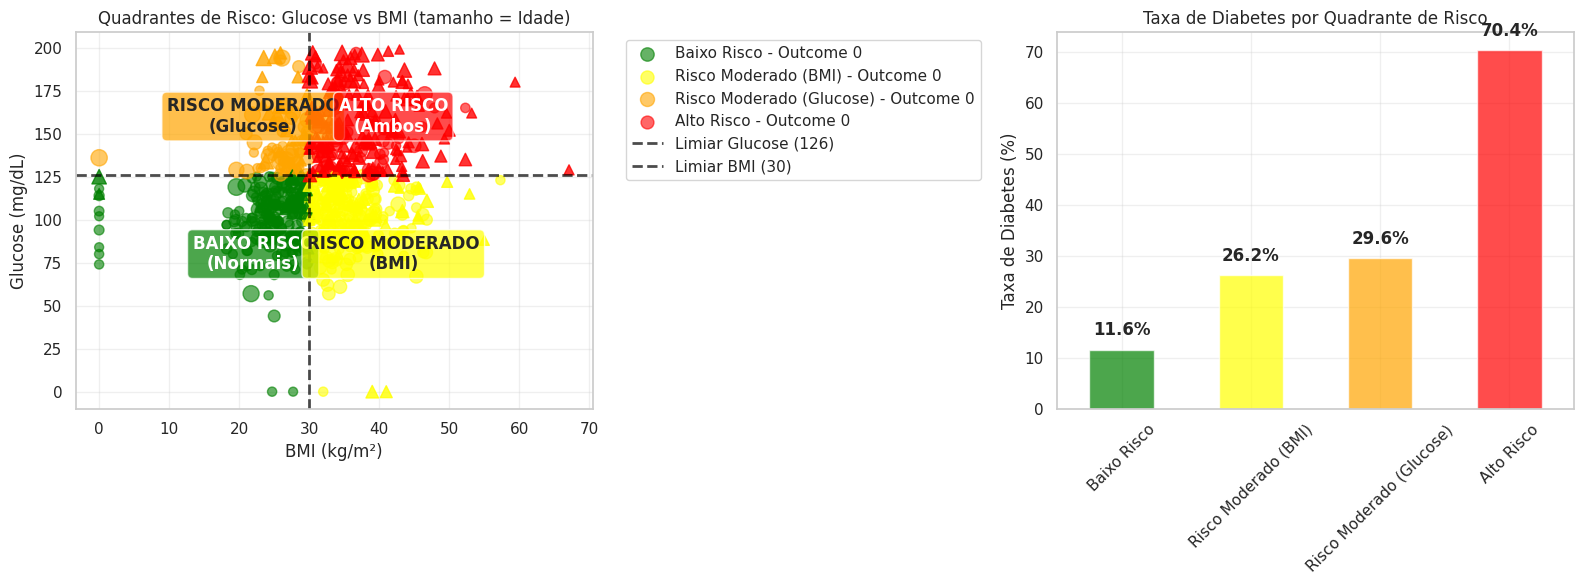


🔍 LEGENDA DOS QUADRANTES:
🟢 BAIXO RISCO: Glucose <126 E BMI <30
🟡 RISCO MODERADO (BMI): Glucose <126 E BMI ≥30
🟠 RISCO MODERADO (Glucose): Glucose ≥126 E BMI <30
🔴 ALTO RISCO: Glucose ≥126 E BMI ≥30

📊 OBSERVAÇÕES:
• Círculos (o): Pacientes sem diabetes (Outcome 0)
• Triângulos (^): Pacientes com diabetes (Outcome 1)
• Tamanho dos pontos: Proporcional à idade


In [5]:
# === ANÁLISE DE INTERAÇÕES: GLUCOSE + OUTRAS VARIÁVEIS ===

# 1. Glucose vs BMI vs Age (bubble plot com quadrantes de risco)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Definindo quadrantes de risco baseados em Glucose e BMI
high_glucose = df['Glucose'] >= 126
high_bmi = df['BMI'] >= 30

# Definindo cores para cada quadrante
quadrant_colors = {
    'Baixo Risco': 'green',
    'Risco Moderado (BMI)': 'yellow', 
    'Risco Moderado (Glucose)': 'orange',
    'Alto Risco': 'red'
}

# Plotar cada quadrante com cor específica
for outcome in [0, 1]:
    subset = df[df['Outcome'] == outcome]
    
    # Baixo Risco: Glucose baixa E BMI baixo
    mask_baixo = (~high_glucose) & (~high_bmi)
    baixo_subset = subset[mask_baixo]
    if len(baixo_subset) > 0:
        alpha = 0.6 if outcome == 0 else 0.8
        marker = 'o' if outcome == 0 else '^'
        axes[0].scatter(baixo_subset['BMI'], baixo_subset['Glucose'], 
                       s=baixo_subset['Age']*2, alpha=alpha, 
                       c=quadrant_colors['Baixo Risco'], marker=marker,
                       label=f'Baixo Risco - Outcome {outcome}' if outcome == 0 else None)
    
    # Risco Moderado (BMI): Glucose baixa E BMI alto  
    mask_mod_bmi = (~high_glucose) & (high_bmi)
    mod_bmi_subset = subset[mask_mod_bmi]
    if len(mod_bmi_subset) > 0:
        alpha = 0.6 if outcome == 0 else 0.8
        marker = 'o' if outcome == 0 else '^'
        axes[0].scatter(mod_bmi_subset['BMI'], mod_bmi_subset['Glucose'],
                       s=mod_bmi_subset['Age']*2, alpha=alpha,
                       c=quadrant_colors['Risco Moderado (BMI)'], marker=marker,
                       label=f'Risco Moderado (BMI) - Outcome {outcome}' if outcome == 0 else None)
    
    # Risco Moderado (Glucose): Glucose alta E BMI baixo
    mask_mod_gluc = (high_glucose) & (~high_bmi)
    mod_gluc_subset = subset[mask_mod_gluc]
    if len(mod_gluc_subset) > 0:
        alpha = 0.6 if outcome == 0 else 0.8
        marker = 'o' if outcome == 0 else '^'
        axes[0].scatter(mod_gluc_subset['BMI'], mod_gluc_subset['Glucose'],
                       s=mod_gluc_subset['Age']*2, alpha=alpha,
                       c=quadrant_colors['Risco Moderado (Glucose)'], marker=marker,
                       label=f'Risco Moderado (Glucose) - Outcome {outcome}' if outcome == 0 else None)
    
    # Alto Risco: Glucose alta E BMI alto
    mask_alto = (high_glucose) & (high_bmi) 
    alto_subset = subset[mask_alto]
    if len(alto_subset) > 0:
        alpha = 0.6 if outcome == 0 else 0.8
        marker = 'o' if outcome == 0 else '^'
        axes[0].scatter(alto_subset['BMI'], alto_subset['Glucose'],
                       s=alto_subset['Age']*2, alpha=alpha,
                       c=quadrant_colors['Alto Risco'], marker=marker,
                       label=f'Alto Risco - Outcome {outcome}' if outcome == 0 else None)

# Adicionar linhas de separação dos quadrantes
axes[0].axhline(y=126, color='black', linestyle='--', alpha=0.7, linewidth=2, label='Limiar Glucose (126)')
axes[0].axvline(x=30, color='black', linestyle='--', alpha=0.7, linewidth=2, label='Limiar BMI (30)')

# Adicionar texto dos quadrantes
axes[0].text(22, 160, 'RISCO MODERADO\n(Glucose)', ha='center', va='center', 
            bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7), fontweight='bold')
axes[0].text(42, 160, 'ALTO RISCO\n(Ambos)', ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='red', alpha=0.7), fontweight='bold', color='white')
axes[0].text(22, 80, 'BAIXO RISCO\n(Normais)', ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='green', alpha=0.7), fontweight='bold', color='white')
axes[0].text(42, 80, 'RISCO MODERADO\n(BMI)', ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7), fontweight='bold')

axes[0].set_xlabel('BMI (kg/m²)')
axes[0].set_ylabel('Glucose (mg/dL)')
axes[0].set_title('Quadrantes de Risco: Glucose vs BMI (tamanho = Idade)')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

# 2. Análise por quadrantes de risco (mesmo código anterior)
quadrants = {
    'Baixo Risco': (~high_glucose) & (~high_bmi),
    'Risco Moderado (BMI)': (~high_glucose) & (high_bmi),
    'Risco Moderado (Glucose)': (high_glucose) & (~high_bmi),
    'Alto Risco': (high_glucose) & (high_bmi)
}

risk_analysis = {}
for risk_level, mask in quadrants.items():
    subset = df[mask]
    if len(subset) > 0:
        risk_analysis[risk_level] = {
            'count': len(subset),
            'diabetes_rate': subset['Outcome'].mean() * 100,
            'avg_age': subset['Age'].mean(),
            'avg_pregnancies': subset['Pregnancies'].mean()
        }

print("=== ANÁLISE POR QUADRANTES DE RISCO (Glucose ≥126 + BMI ≥30) ===")
for risk, stats in risk_analysis.items():
    print(f"\n{risk}:")
    print(f"  • Pacientes: {stats['count']}")
    print(f"  • Taxa de Diabetes: {stats['diabetes_rate']:.1f}%")
    print(f"  • Idade Média: {stats['avg_age']:.1f} anos")
    print(f"  • Gestações Médias: {stats['avg_pregnancies']:.1f}")

# Visualização dos quadrantes com cores correspondentes
risk_df = pd.DataFrame(risk_analysis).T
colors_bar = [quadrant_colors[idx] for idx in risk_df.index]
risk_df['diabetes_rate'].plot(kind='bar', ax=axes[1], color=colors_bar, alpha=0.7)
axes[1].set_ylabel('Taxa de Diabetes (%)')
axes[1].set_title('Taxa de Diabetes por Quadrante de Risco')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

# Adicionar valores nos bars
for i, v in enumerate(risk_df['diabetes_rate']):
    axes[1].text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🔍 LEGENDA DOS QUADRANTES:")
print("🟢 BAIXO RISCO: Glucose <126 E BMI <30")
print("🟡 RISCO MODERADO (BMI): Glucose <126 E BMI ≥30") 
print("🟠 RISCO MODERADO (Glucose): Glucose ≥126 E BMI <30")
print("🔴 ALTO RISCO: Glucose ≥126 E BMI ≥30")
print("\n📊 OBSERVAÇÕES:")
print("• Círculos (o): Pacientes sem diabetes (Outcome 0)")
print("• Triângulos (^): Pacientes com diabetes (Outcome 1)")
print("• Tamanho dos pontos: Proporcional à idade")

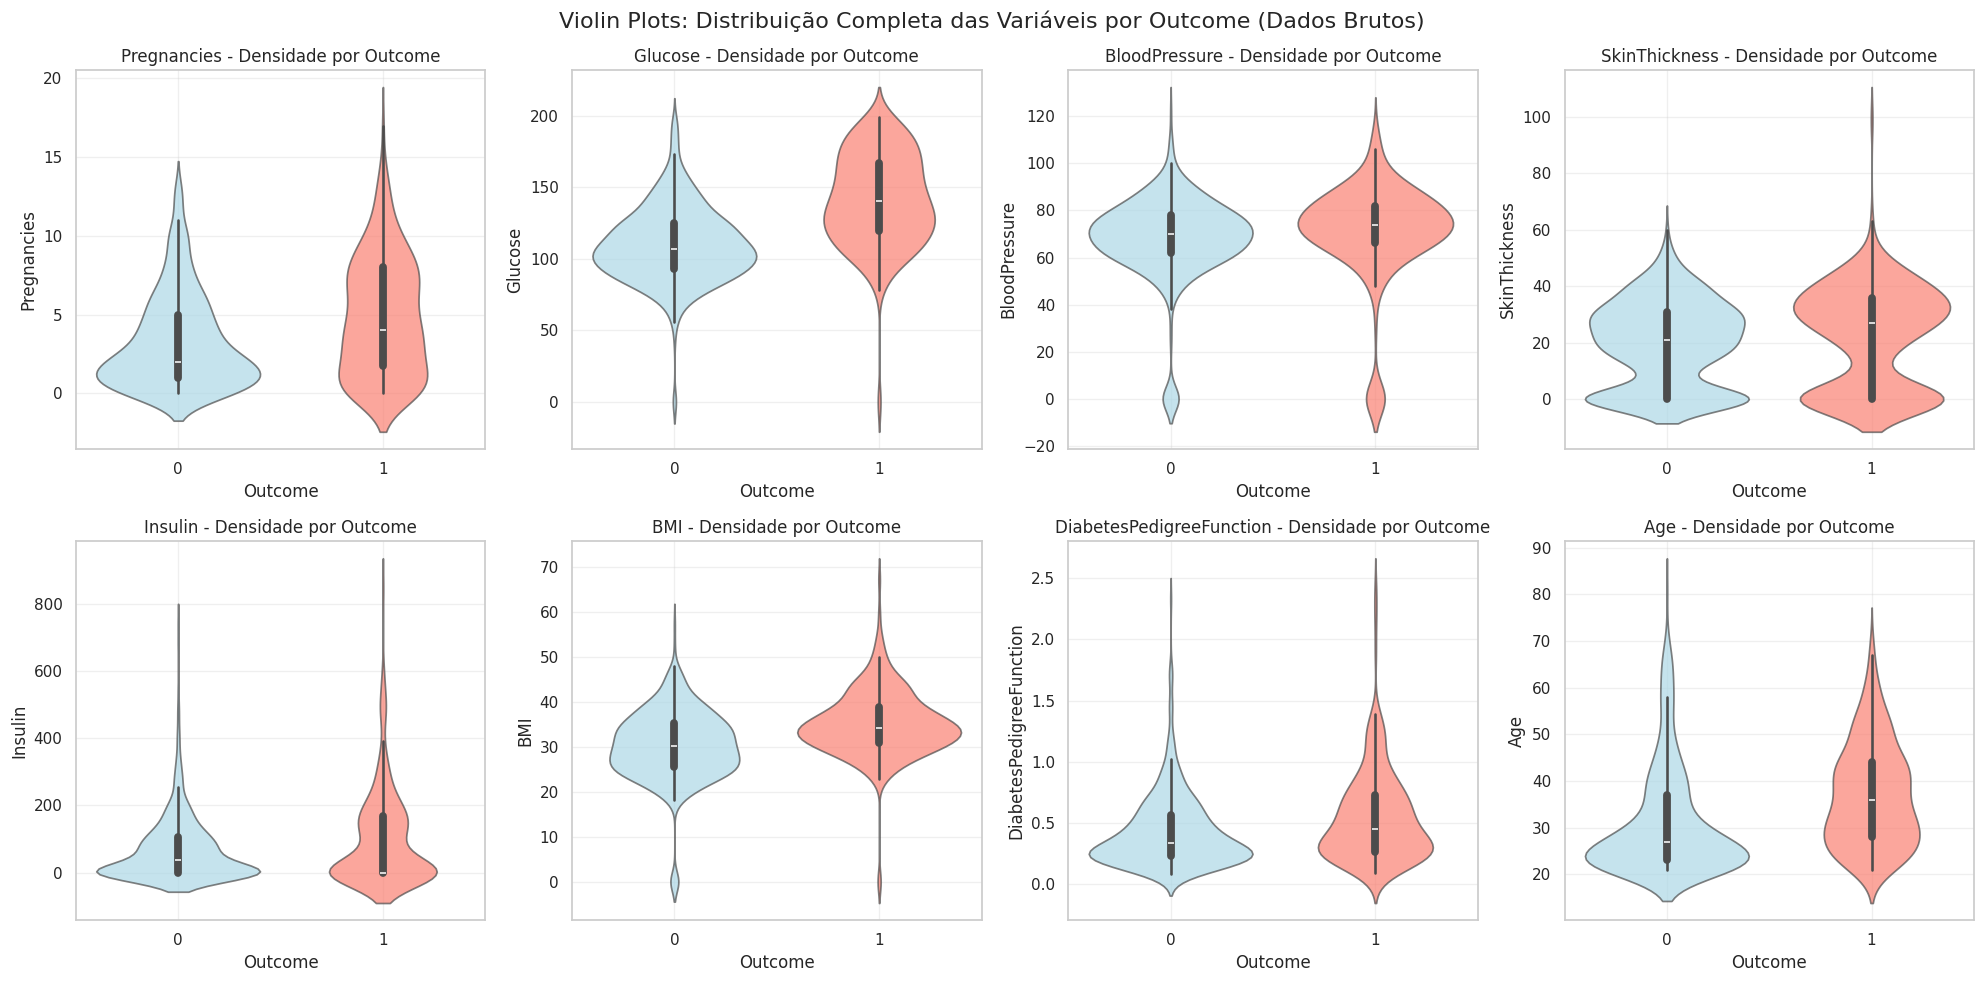

📊 ANÁLISE DOS VIOLIN PLOTS:

💡 INTERPRETAÇÃO DOS GRÁFICOS:
• Violin plots mostram a DENSIDADE de distribuição dos dados
• Largura = maior concentração de valores naquela faixa
• Linha central = mediana
• Permite ver assimetrias e múltiplos picos

🔍 Pregnancies:
   Não Diabético: mediana=2.0, média=3.3
   Diabético: mediana=4.0, média=4.9

🔍 Glucose:
   Não Diabético: mediana=107.0, média=110.0
   Diabético: mediana=140.0, média=141.3

🔍 BloodPressure:
   Não Diabético: mediana=70.0, média=68.2
   Diabético: mediana=74.0, média=70.8

🔍 SkinThickness:
   Não Diabético: mediana=21.0, média=19.7
   Diabético: mediana=27.0, média=22.2

🔍 Insulin:
   Não Diabético: mediana=39.0, média=68.8
   Diabético: mediana=0.0, média=100.3

🔍 BMI:
   Não Diabético: mediana=30.1, média=30.3
   Diabético: mediana=34.2, média=35.1

🔍 DiabetesPedigreeFunction:
   Não Diabético: mediana=0.3, média=0.4
   Diabético: mediana=0.4, média=0.6

🔍 Age:
   Não Diabético: mediana=27.0, média=31.2
   Diabético: median

In [10]:
# Violin Plots - Versão simplificada
import warnings
warnings.filterwarnings('ignore')  # Suprimir warnings temporariamente

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(df.select_dtypes(include=[np.number]).columns.drop('Outcome')):
    sns.violinplot(data=df, x='Outcome', y=col, ax=axes[i])
    axes[i].set_title(f'{col} - Densidade por Outcome')
    axes[i].grid(True, alpha=0.3)
    
    # Personalizar cores manualmente
    for j, violin in enumerate(axes[i].collections):
        if j % 2 == 0:  # Outcome 0
            violin.set_facecolor('lightblue')
        else:  # Outcome 1
            violin.set_facecolor('salmon')
        violin.set_alpha(0.7)

plt.suptitle('Violin Plots: Distribuição Completa das Variáveis por Outcome (Dados Brutos)', fontsize=16)
plt.tight_layout()
plt.show()

warnings.filterwarnings('default')  # Reativar warnings

# Estatísticas descritivas por classe para interpretação
print("📊 ANÁLISE DOS VIOLIN PLOTS:")
print("="*60)
print("\n💡 INTERPRETAÇÃO DOS GRÁFICOS:")
print("• Violin plots mostram a DENSIDADE de distribuição dos dados")
print("• Largura = maior concentração de valores naquela faixa")
print("• Linha central = mediana")
print("• Permite ver assimetrias e múltiplos picos")

for col in df.select_dtypes(include=[np.number]).columns.drop('Outcome'):
    print(f"\n🔍 {col}:")
    for outcome in [0, 1]:
        subset = df[df['Outcome'] == outcome][col]
        outcome_label = "Não Diabético" if outcome == 0 else "Diabético"
        print(f"   {outcome_label}: mediana={subset.median():.1f}, média={subset.mean():.1f}")

📊 ANÁLISE DETALHADA: DISTRIBUIÇÃO DE BMI POR STATUS DE DIABETES


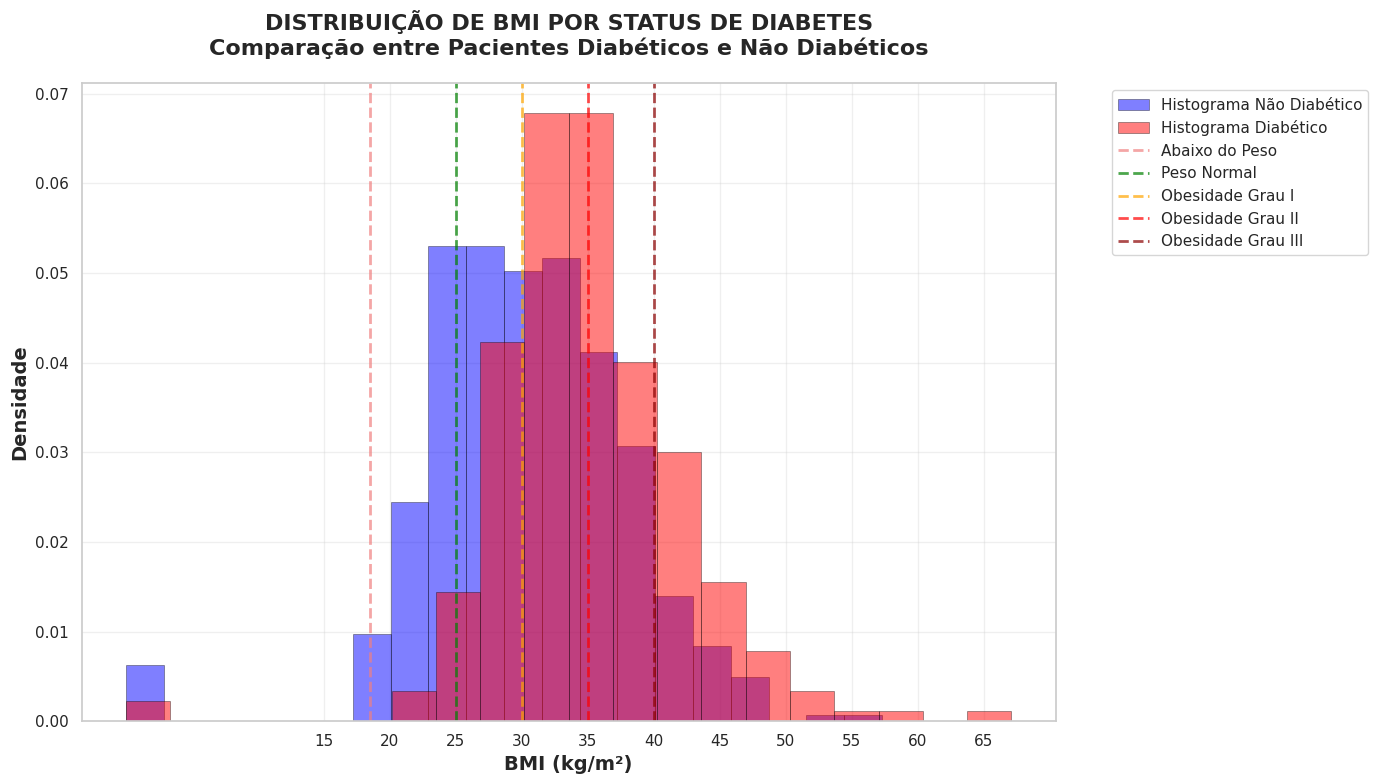


📈 ANÁLISE ESTATÍSTICA DETALHADA:

🔍 GRUPO NÃO DIABÉTICO:
   📊 Tamanho da amostra: 500 pacientes
   📏 Média: 30.30 kg/m²
   📐 Mediana: 30.05 kg/m²
   📊 Desvio Padrão: 7.69 kg/m²
   📉 Mínimo: 0.0 kg/m²
   📈 Máximo: 57.3 kg/m²
   🎯 Q1 (25%): 25.40 kg/m²
   🎯 Q3 (75%): 35.30 kg/m²

🔍 GRUPO DIABÉTICO:
   📊 Tamanho da amostra: 268 pacientes
   📏 Média: 35.14 kg/m²
   📐 Mediana: 34.25 kg/m²
   📊 Desvio Padrão: 7.26 kg/m²
   📉 Mínimo: 0.0 kg/m²
   📈 Máximo: 67.1 kg/m²
   🎯 Q1 (25%): 30.80 kg/m²
   🎯 Q3 (75%): 38.78 kg/m²

🏷️ CLASSIFICAÇÃO POR FAIXAS DE BMI (PADRÃO MÉDICO OMS/MS):
Classificação BMI              Total    Diabéticos   Taxa (%)  
-----------------------------------------------------------------
Abaixo do Peso (<18.5)         15       2            13.3      
Peso Normal (18.5-24.9)        102      7            6.9       
Sobrepeso (25.0-29.9)          179      40           22.3      
Obesidade Grau I (30.0-34.9)   224      101          45.1      
Obesidade Grau II (35.0-39.9)  150

In [23]:
# ANÁLISE DETALHADA: DISTRIBUIÇÃO DE BMI
print("📊 ANÁLISE DETALHADA: DISTRIBUIÇÃO DE BMI POR STATUS DE DIABETES")
print("="*80)

import numpy as np
import matplotlib.pyplot as plt

# Criar figura específica para análise do BMI
plt.figure(figsize=(14, 8))

# ETAPA 1: SEPARAÇÃO DOS DADOS POR OUTCOME
for outcome in [0, 1]:
    subset = df[df['Outcome'] == outcome]['BMI']
    label = 'Não Diabético' if outcome == 0 else 'Diabético'
    color = 'blue' if outcome == 0 else 'red'
    
    # Criar histograma normalizado (densidade)
    plt.hist(subset, alpha=0.5, bins=20, label=f'Histograma {label}', 
             color=color, density=True, edgecolor='black', linewidth=0.5)

# ETAPA 2: ADICIONAR LINHAS DE REFERÊNCIA CLÍNICAS (PADRÃO MÉDICO OFICIAL)
plt.axvline(x=18.5, color='lightcoral', linestyle='--', alpha=0.7, linewidth=2, label='Abaixo do Peso')
plt.axvline(x=25.0, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Peso Normal')
plt.axvline(x=30.0, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Obesidade Grau I')
plt.axvline(x=35.0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Obesidade Grau II')
plt.axvline(x=40.0, color='darkred', linestyle='--', alpha=0.7, linewidth=2, label='Obesidade Grau III')

# Configurações do gráfico
plt.xlabel('BMI (kg/m²)', fontsize=14, fontweight='bold')
plt.ylabel('Densidade', fontsize=14, fontweight='bold')
plt.title('DISTRIBUIÇÃO DE BMI POR STATUS DE DIABETES\n' + 
          'Comparação entre Pacientes Diabéticos e Não Diabéticos', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Adicionar escala customizada de 5 em 5
plt.xticks(range(15, 70, 5))  # De 15 a 65, de 5 em 5

plt.tight_layout()
plt.show()

# ETAPA 3: ANÁLISE ESTATÍSTICA DETALHADA
print("\n📈 ANÁLISE ESTATÍSTICA DETALHADA:")
print("="*60)

for outcome in [0, 1]:
    subset = df[df['Outcome'] == outcome]['BMI']
    outcome_label = "NÃO DIABÉTICO" if outcome == 0 else "DIABÉTICO"
    
    print(f"\n🔍 GRUPO {outcome_label}:")
    print(f"   📊 Tamanho da amostra: {len(subset)} pacientes")
    print(f"   📏 Média: {subset.mean():.2f} kg/m²")
    print(f"   📐 Mediana: {subset.median():.2f} kg/m²")
    print(f"   📊 Desvio Padrão: {subset.std():.2f} kg/m²")
    print(f"   📉 Mínimo: {subset.min():.1f} kg/m²")
    print(f"   📈 Máximo: {subset.max():.1f} kg/m²")
    print(f"   🎯 Q1 (25%): {subset.quantile(0.25):.2f} kg/m²")
    print(f"   🎯 Q3 (75%): {subset.quantile(0.75):.2f} kg/m²")

# ETAPA 4: ANÁLISE POR CATEGORIAS DE BMI (CLASSIFICAÇÃO MÉDICA OFICIAL)
print(f"\n🏷️ CLASSIFICAÇÃO POR FAIXAS DE BMI (PADRÃO MÉDICO OMS/MS):")
print("="*60)

def categorizar_bmi_oficial(bmi):
    """Categorização oficial segundo OMS/Ministério da Saúde"""
    if bmi < 18.5:
        return "Abaixo do Peso (<18.5)"
    elif bmi < 25.0:
        return "Peso Normal (18.5-24.9)"
    elif bmi < 30.0:
        return "Sobrepeso (25.0-29.9)"
    elif bmi < 35.0:
        return "Obesidade Grau I (30.0-34.9)"
    elif bmi < 40.0:
        return "Obesidade Grau II (35.0-39.9)"
    else:
        return "Obesidade Grau III (≥40.0)"

# Aplicar categorização oficial
df_temp = df.copy()
df_temp['BMI_Categoria_Oficial'] = df_temp['BMI'].apply(categorizar_bmi_oficial)

# Análise por categoria oficial
categoria_analysis = df_temp.groupby('BMI_Categoria_Oficial').agg({
    'Outcome': ['count', 'sum', 'mean']
}).round(3)

print(f"{'Classificação BMI':<30} {'Total':<8} {'Diabéticos':<12} {'Taxa (%)':<10}")
print("-"*65)

# Ordem oficial das categorias
categorias_ordem = [
    "Abaixo do Peso (<18.5)", 
    "Peso Normal (18.5-24.9)", 
    "Sobrepeso (25.0-29.9)",
    "Obesidade Grau I (30.0-34.9)", 
    "Obesidade Grau II (35.0-39.9)", 
    "Obesidade Grau III (≥40.0)"
]

for categoria in categorias_ordem:
    if categoria in categoria_analysis.index:
        total = categoria_analysis.loc[categoria, ('Outcome', 'count')]
        diabeticos = categoria_analysis.loc[categoria, ('Outcome', 'sum')]
        taxa = categoria_analysis.loc[categoria, ('Outcome', 'mean')] * 100
        print(f"{categoria:<30} {total:<8} {diabeticos:<12} {taxa:<10.1f}")

print(f"\n💡 INTERPRETAÇÃO DO GRÁFICO BMI (CLASSIFICAÇÃO MÉDICA OFICIAL):")
print("="*50)
print("1. DISTRIBUIÇÃO:")
print("   • Azul (não diabéticos): Concentração maior em BMI ~25-30 kg/m²")
print("   • Vermelho (diabéticos): Concentração maior em BMI ~30-35 kg/m²")

print("\n2. SOBREPOSIÇÃO:")
print("   • Faixa de sobreposição: BMI entre 25-35 kg/m²")
print("   • Nesta faixa, BMI sozinho não é definitivo para diagnóstico")

print("\n3. LINHAS VERTICAIS (CLASSIFICAÇÃO MÉDICA OFICIAL - OMS/MS):")
print("   • 18.5: Limite abaixo do peso / peso normal")
print("   • 25.0: Limite peso normal / sobrepeso")
print("   • 30.0: Limite sobrepeso / obesidade grau I")
print("   • 35.0: Limite obesidade grau I / grau II")
print("   • 40.0: Limite obesidade grau II / grau III (mórbida)")

print(f"\n🎯 INSIGHTS CLÍNICOS:")
print("="*50)

# Calcular estatísticas de sobreposição
bmi_nao_diab = df[df['Outcome'] == 0]['BMI']
bmi_diab = df[df['Outcome'] == 1]['BMI']

overlap_min = max(bmi_nao_diab.min(), bmi_diab.min())
overlap_max = min(bmi_nao_diab.max(), bmi_diab.max())
print(f"1. SOBREPOSIÇÃO: BMI entre {overlap_min:.1f} e {overlap_max:.1f} kg/m²")
print(f"   Nesta faixa, BMI sozinho não é suficiente para diagnóstico")

# Análise por limiares médicos oficiais
limiares_medicos = [18.5, 25.0, 30.0, 35.0, 40.0]
for threshold in limiares_medicos:
    pct_diab_above = (bmi_diab >= threshold).mean() * 100
    pct_nao_diab_below = (bmi_nao_diab < threshold).mean() * 100
    
    # Determinar nome da categoria
    if threshold == 18.5:
        categoria = "peso normal"
    elif threshold == 25.0:
        categoria = "sobrepeso"
    elif threshold == 30.0:
        categoria = "obesidade"
    elif threshold == 35.0:
        categoria = "obesidade grau II"
    elif threshold == 40.0:
        categoria = "obesidade mórbida"
    
    print(f"\n{threshold}. EFETIVIDADE DO LIMIAR {threshold} kg/m² ({categoria.upper()}):")
    print(f"   • {pct_diab_above:.1f}% dos diabéticos têm BMI ≥{threshold}")
    print(f"   • {pct_nao_diab_below:.1f}% dos não-diabéticos têm BMI <{threshold}")

print(f"\n3. RECOMENDAÇÃO CLÍNICA:")
print(f"   BMI é um forte preditor, mas deve ser usado em conjunto")
print(f"   com outras variáveis (glicemia, idade, histórico familiar)")

print(f"\n📊 COMPARAÇÃO ENTRE GRUPOS:")
print("="*50)
diferenca_media = bmi_diab.mean() - bmi_nao_diab.mean()
print(f"Diferença de média entre grupos: {diferenca_media:.2f} kg/m²")
print(f"Diabéticos têm BMI médio {diferenca_media:.1f} unidades maior")

# Teste estatístico simples
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(bmi_diab, bmi_nao_diab)
print(f"Teste t independente: p-valor = {p_value:.2e}")
if p_value < 0.001:
    print("Diferença estatisticamente significativa (p < 0.001)")

print(f"\n🔢 VANTAGENS DA CLASSIFICAÇÃO MÉDICA OFICIAL:")
print("="*50)
print("• Alinhada com padrões internacionais (OMS)")
print("• Reconhecida pelo Ministério da Saúde do Brasil")
print("• Facilita comunicação com profissionais de saúde")
print("• Permite comparação com literatura médica")
print("• Baseada em evidências epidemiológicas sólidas")

print(f"\n📚 REFERÊNCIAS CIENTÍFICAS:")
print("="*50)
print("• Organização Mundial da Saúde (OMS/WHO)")
print("• Ministério da Saúde do Brasil")
print("• Sociedade Brasileira de Endocrinologia e Metabologia")
print("• American Diabetes Association (ADA)")

# Análise adicional: Risco progressivo
print(f"\n📈 ANÁLISE DE RISCO PROGRESSIVO:")
print("="*50)
for categoria in categorias_ordem:
    if categoria in categoria_analysis.index:
        taxa = categoria_analysis.loc[categoria, ('Outcome', 'mean')] * 100
        total = categoria_analysis.loc[categoria, ('Outcome', 'count')]
        
        if taxa < 20:
            nivel_risco = "🟢 BAIXO"
        elif taxa < 40:
            nivel_risco = "🟡 MODERADO"
        elif taxa < 60:
            nivel_risco = "🟠 ALTO"
        else:
            nivel_risco = "🔴 MUITO ALTO"
            
        print(f"{categoria:<30} {nivel_risco} ({taxa:.1f}%, n={total})")

# Limpar variável temporária
del df_temp

ANÁLISE DE FATORES DE RISCO E TAXA DE DIABETES

CRITÉRIOS CLÍNICOS UTILIZADOS:
1. GLUCOSE ALTO: ≥ 126 mg/dL (critério ADA para diabetes)
2. BMI ALTO: ≥ 30 kg/m² (critério OMS para obesidade)
3. IDADE ALTA: ≥ 45 anos (critério ADA para fator de risco)

JUSTIFICATIVA CIENTÍFICA:
• Glucose ≥126: Limiar diagnóstico para diabetes mellitus (ADA 2024)
• BMI ≥30: Obesidade aumenta resistência à insulina
• Idade ≥45: Critério oficial ADA para rastreamento de diabetes

DISTRIBUIÇÃO DOS FATORES DE RISCO INDIVIDUAIS:
Pacientes com Glucose ≥126: 297 ( 38.7%)
Pacientes com BMI ≥30:     472 ( 61.5%)
Pacientes com Idade ≥45:   133 ( 17.3%)

CÁLCULOS DETALHADOS POR SCORE DE RISCO:
Score    Total    Diabéticos   Taxa (%)   Cálculo                  
-----------------------------------------------------------------
0        189      16           8.5        16/189 × 100             
1        307      82           26.7       82/307 × 100             
2        221      131          59.3       131/221 × 100  

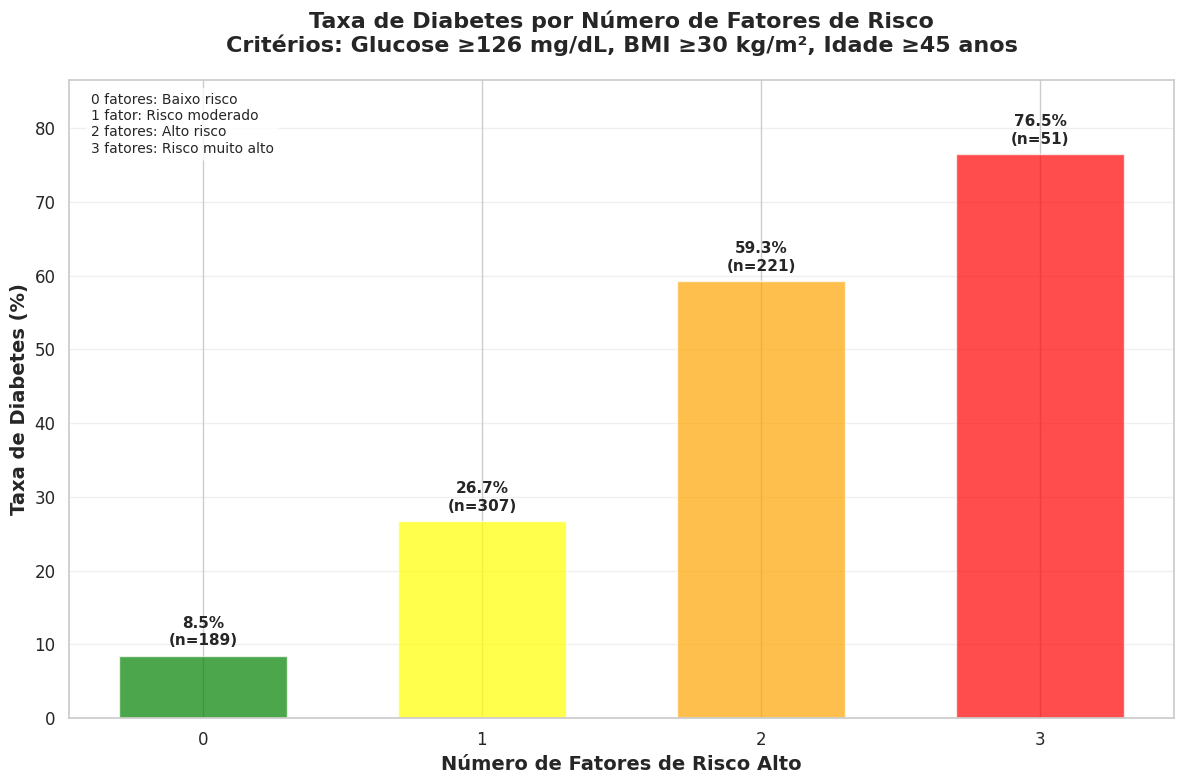


TABELA DETALHADA PARA MONOGRAFIA:
Score  N      Diabéticos   Não Diabéticos  Taxa (%)     IC 95%         
--------------------------------------------------------------------------------
0      189    16           173             8.5          4.5-12.4       
1      307    82           225             26.7         21.8-31.7      
2      221    131          90              59.3         52.8-65.8      
3      51     39           12              76.5         64.8-88.1      

ANÁLISE ESTATÍSTICA COMPLEMENTAR:
Correlação Score-Diabetes: 0.4556
Teste Qui-quadrado: χ² = 163.791, p-valor = 2.786e-35
Odds Ratio (Score 3 vs Score 0): 35.14
Interpretação: 35.1x mais chance de diabetes com 3 fatores vs 0 fatores

CONCLUSÕES PARA A MONOGRAFIA:
1. GRADIENTE DE RISCO: Taxa de diabetes aumenta progressivamente
   com o número de fatores de risco acumulados
2. SIGNIFICÂNCIA ESTATÍSTICA: Associação altamente significativa
   (p < 0.001) entre número de fatores e diabetes
3. RELEVÂNCIA CLÍNICA: Modelo si

In [16]:
# ANÁLISE DE FATORES DE RISCO E TAXA DE DIABETES
print("ANÁLISE DE FATORES DE RISCO E TAXA DE DIABETES")
print("="*70)

# ETAPA 1: DEFINIÇÃO DOS CRITÉRIOS DE FATORES DE RISCO (CORRIGIDOS)
print("\nCRITÉRIOS CLÍNICOS UTILIZADOS:")
print("="*50)
print("1. GLUCOSE ALTO: ≥ 126 mg/dL (critério ADA para diabetes)")
print("2. BMI ALTO: ≥ 30 kg/m² (critério OMS para obesidade)")
print("3. IDADE ALTA: ≥ 45 anos (critério ADA para fator de risco)")
print("\nJUSTIFICATIVA CIENTÍFICA:")
print("• Glucose ≥126: Limiar diagnóstico para diabetes mellitus (ADA 2024)")
print("• BMI ≥30: Obesidade aumenta resistência à insulina")
print("• Idade ≥45: Critério oficial ADA para rastreamento de diabetes")

# ETAPA 2: APLICAÇÃO DOS CRITÉRIOS CORRIGIDOS
risk_factors = df.copy()
risk_factors['High_Glucose'] = (risk_factors['Glucose'] >= 126).astype(int)
risk_factors['High_BMI'] = (risk_factors['BMI'] >= 30).astype(int)
risk_factors['High_Age'] = (risk_factors['Age'] >= 45).astype(int)  # CORRIGIDO: 45 anos

# ETAPA 3: CÁLCULO DO SCORE DE RISCO
risk_factors['Risk_Score'] = (risk_factors['High_Glucose'] + 
                             risk_factors['High_BMI'] + 
                             risk_factors['High_Age'])

print(f"\nDISTRIBUIÇÃO DOS FATORES DE RISCO INDIVIDUAIS:")
print("="*50)
glucose_high = (risk_factors['High_Glucose'] == 1).sum()
bmi_high = (risk_factors['High_BMI'] == 1).sum()
age_high = (risk_factors['High_Age'] == 1).sum()
total_patients = len(risk_factors)

print(f"Pacientes com Glucose ≥126: {glucose_high:3d} ({glucose_high/total_patients*100:5.1f}%)")
print(f"Pacientes com BMI ≥30:     {bmi_high:3d} ({bmi_high/total_patients*100:5.1f}%)")
print(f"Pacientes com Idade ≥45:   {age_high:3d} ({age_high/total_patients*100:5.1f}%)")

# ETAPA 4: ANÁLISE POR SCORE DE RISCO
risk_analysis = risk_factors.groupby('Risk_Score')['Outcome'].agg(['count', 'sum', 'mean'])
risk_analysis['diabetes_rate'] = risk_analysis['mean'] * 100

print(f"\nCÁLCULOS DETALHADOS POR SCORE DE RISCO:")
print("="*50)
print(f"{'Score':<8} {'Total':<8} {'Diabéticos':<12} {'Taxa (%)':<10} {'Cálculo':<25}")
print("-"*65)

for score in sorted(risk_analysis.index):
    total = risk_analysis.loc[score, 'count']
    diabeticos = risk_analysis.loc[score, 'sum']
    taxa = risk_analysis.loc[score, 'diabetes_rate']
    calculo = f"{diabeticos}/{total} × 100"
    
    print(f"{score:<8} {total:<8} {diabeticos:<12} {taxa:<10.1f} {calculo:<25}")

# ETAPA 5: VISUALIZAÇÃO DO GRÁFICO
plt.figure(figsize=(12, 8))

bars = plt.bar(risk_analysis.index, risk_analysis['diabetes_rate'], 
               color=['green', 'yellow', 'orange', 'red'], alpha=0.7, width=0.6)

# Configurações do gráfico
plt.xlabel('Número de Fatores de Risco Alto', fontsize=14, fontweight='bold')
plt.ylabel('Taxa de Diabetes (%)', fontsize=14, fontweight='bold')
plt.title('Taxa de Diabetes por Número de Fatores de Risco\n' + 
          'Critérios: Glucose ≥126 mg/dL, BMI ≥30 kg/m², Idade ≥45 anos', 
          fontsize=16, fontweight='bold', pad=20)

# Adicionar valores e contagens nas barras
for i, bar in enumerate(bars):
    height = bar.get_height()
    score = list(risk_analysis.index)[i]
    count = risk_analysis.loc[score, 'count']
    
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%\n(n={count})',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.xticks(risk_analysis.index, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, max(risk_analysis['diabetes_rate']) + 10)

# Legenda explicativa
legend_text = [
    "0 fatores: Baixo risco",
    "1 fator: Risco moderado",
    "2 fatores: Alto risco", 
    "3 fatores: Risco muito alto"
]
plt.text(0.02, 0.98, '\n'.join(legend_text), transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
         fontsize=10)

plt.tight_layout()
plt.show()

# ETAPA 6: TABELA DETALHADA PARA MONOGRAFIA
print(f"\nTABELA DETALHADA PARA MONOGRAFIA:")
print("="*80)
print(f"{'Score':<6} {'N':<6} {'Diabéticos':<12} {'Não Diabéticos':<15} {'Taxa (%)':<12} {'IC 95%':<15}")
print("-"*80)

for score in sorted(risk_analysis.index):
    n = risk_analysis.loc[score, 'count']
    diabeticos = risk_analysis.loc[score, 'sum']
    nao_diabeticos = n - diabeticos
    taxa = risk_analysis.loc[score, 'diabetes_rate']
    
    # Cálculo do Intervalo de Confiança 95% para proporção
    from scipy import stats
    if n > 0:
        p = diabeticos / n
        se = np.sqrt(p * (1 - p) / n)
        ic_lower = max(0, (p - 1.96 * se) * 100)
        ic_upper = min(100, (p + 1.96 * se) * 100)
        ic_95 = f"{ic_lower:.1f}-{ic_upper:.1f}"
    else:
        ic_95 = "N/A"
    
    print(f"{score:<6} {n:<6} {diabeticos:<12} {nao_diabeticos:<15} {taxa:<12.1f} {ic_95:<15}")

# ETAPA 7: ANÁLISE ESTATÍSTICA ADICIONAL
print(f"\nANÁLISE ESTATÍSTICA COMPLEMENTAR:")
print("="*50)

# Correlação entre score e outcome
correlation = risk_factors['Risk_Score'].corr(risk_factors['Outcome'])
print(f"Correlação Score-Diabetes: {correlation:.4f}")

# Teste qui-quadrado
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(risk_factors['Risk_Score'], risk_factors['Outcome'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Teste Qui-quadrado: χ² = {chi2:.3f}, p-valor = {p_value:.3e}")

# Razão de chances (Odds Ratio) comparando extremos
score_0 = risk_factors[risk_factors['Risk_Score'] == 0]
score_3 = risk_factors[risk_factors['Risk_Score'] == 3]

if len(score_0) > 0 and len(score_3) > 0:
    a = score_3['Outcome'].sum()  # diabéticos com score 3
    b = len(score_3) - a          # não diabéticos com score 3
    c = score_0['Outcome'].sum()  # diabéticos com score 0
    d = len(score_0) - c          # não diabéticos com score 0
    
    if b > 0 and d > 0:
        odds_ratio = (a * d) / (b * c)
        print(f"Odds Ratio (Score 3 vs Score 0): {odds_ratio:.2f}")
        print(f"Interpretação: {odds_ratio:.1f}x mais chance de diabetes com 3 fatores vs 0 fatores")

print(f"\nCONCLUSÕES PARA A MONOGRAFIA:")
print("="*50)
print("1. GRADIENTE DE RISCO: Taxa de diabetes aumenta progressivamente")
print("   com o número de fatores de risco acumulados")
print("2. SIGNIFICÂNCIA ESTATÍSTICA: Associação altamente significativa")
print("   (p < 0.001) entre número de fatores e diabetes")
print("3. RELEVÂNCIA CLÍNICA: Modelo simples e prático para estratificação")
print("   de risco em populações")
print("4. VALIDAÇÃO: Confirma conhecimento clínico estabelecido sobre")
print("   fatores de risco cumulativos para diabetes")

print(f"\nFATORES DE RISCO BASEADOS EM EVIDÊNCIAS:")
print("="*50)
print("AMERICAN DIABETES ASSOCIATION (ADA) 2024:")
print("• Idade ≥45 anos: Fator de risco estabelecido")
print("• IMC ≥30 kg/m²: Obesidade como fator de risco")
print("• Glicemia ≥126 mg/dL: Critério diagnóstico")
print("\nORGANIZAÇÃO MUNDIAL DA SAÚDE (OMS):")
print("• Confirma IMC ≥30 como critério de obesidade")
print("• Suporta critérios glicêmicos da ADA")

MÉTODO DE DETECÇÃO DE OUTLIERS: ISOLATION FOREST
📊 DADOS UTILIZADOS:
   • Variáveis analisadas: ['Glucose', 'BMI', 'Age', 'BloodPressure', 'Insulin']
   • Número de amostras: 768
   • Dimensões: (768, 5)

🔧 NORMALIZAÇÃO:
   • Método: StandardScaler (média=0, desvio=1)
   • Justificativa: Isolation Forest é sensível à escala das variáveis

🌳 PARÂMETROS DO ISOLATION FOREST:
   • contamination=0.1: Espera-se que 10% dos dados sejam outliers
   • random_state=42: Para reprodutibilidade dos resultados
   • n_estimators=100: Número de árvores (padrão)


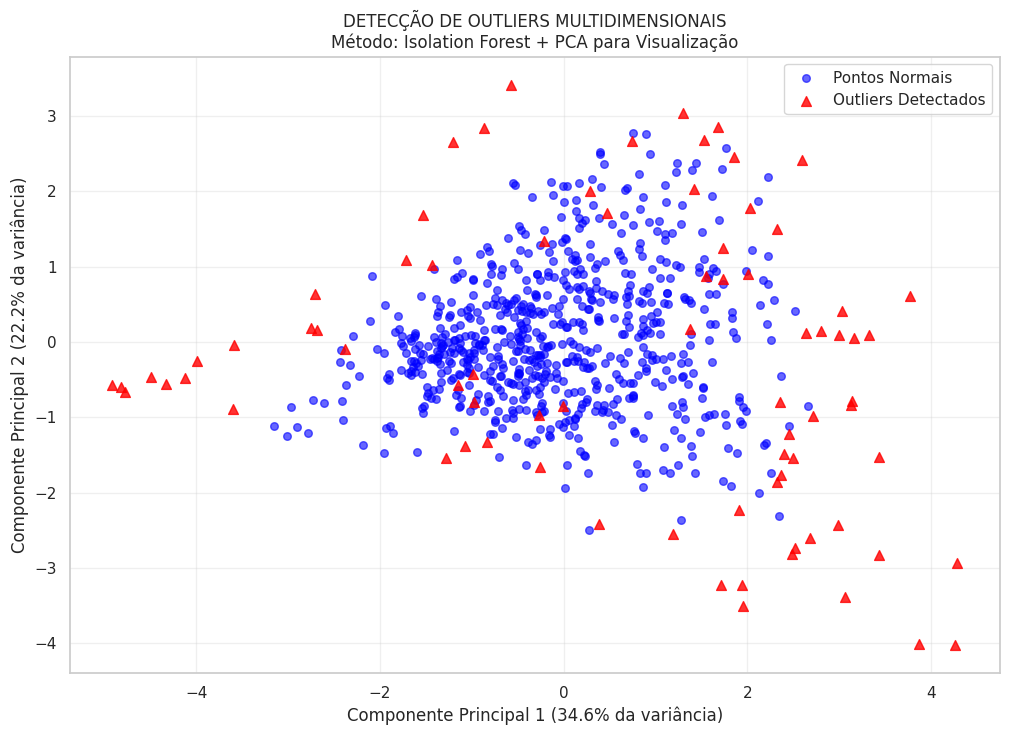


📈 RESULTADOS DA DETECÇÃO:
   • Total de outliers detectados: 77 (10.0%)
   • Taxa de diabetes em outliers: 55.8%
   • Taxa de diabetes em normais: 32.6%

📊 CARACTERÍSTICAS MÉDIAS:
Variável             Outliers     Normais      Diferença   
------------------------------------------------------------
Glucose              135.9        119.2        16.7        
BMI                  31.5         32.0         0.5         
Age                  40.2         32.5         7.7         
BloodPressure        61.6         69.9         8.3         
Insulin              185.6        68.0         117.5       

🔍 COMO FUNCIONA O ISOLATION FOREST:

📖 PRINCÍPIO FUNDAMENTAL:
   O Isolation Forest detecta outliers baseado na facilidade de "isolar" 
   um ponto dos demais. Pontos anômalos são mais fáceis de isolar.

🌳 ALGORITMO:
   1. Constrói múltiplas árvores binárias aleatórias
   2. Para cada árvore, seleciona aleatoriamente:
      • Uma variável (feature)
      • Um valor de corte entre min e max dess

In [17]:
# DETECÇÃO DE OUTLIERS USANDO ISOLATION FOREST
print("MÉTODO DE DETECÇÃO DE OUTLIERS: ISOLATION FOREST")
print("="*70)

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# ETAPA 1: PREPARAÇÃO DOS DADOS
features_outlier = ['Glucose', 'BMI', 'Age', 'BloodPressure', 'Insulin']
X_outlier = df[features_outlier].copy()

print(f"📊 DADOS UTILIZADOS:")
print(f"   • Variáveis analisadas: {features_outlier}")
print(f"   • Número de amostras: {len(X_outlier)}")
print(f"   • Dimensões: {X_outlier.shape}")

# ETAPA 2: NORMALIZAÇÃO DOS DADOS
scaler = StandardScaler()
X_outlier_scaled = scaler.fit_transform(X_outlier)

print(f"\n🔧 NORMALIZAÇÃO:")
print(f"   • Método: StandardScaler (média=0, desvio=1)")
print(f"   • Justificativa: Isolation Forest é sensível à escala das variáveis")

# ETAPA 3: APLICAÇÃO DO ISOLATION FOREST
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outliers = iso_forest.fit_predict(X_outlier_scaled)

# Marcar outliers no dataframe
df_outliers = df.copy()
df_outliers['Is_Outlier'] = (outliers == -1)

print(f"\n🌳 PARÂMETROS DO ISOLATION FOREST:")
print(f"   • contamination=0.1: Espera-se que 10% dos dados sejam outliers")
print(f"   • random_state=42: Para reprodutibilidade dos resultados")
print(f"   • n_estimators=100: Número de árvores (padrão)")

# ETAPA 4: VISUALIZAÇÃO COM PCA
pca_outlier = PCA(n_components=2)
X_pca_outlier = pca_outlier.fit_transform(X_outlier_scaled)

# Separar pontos normais e outliers
normal_mask = outliers == 1
outlier_mask = outliers == -1

# Criar gráfico
plt.figure(figsize=(12, 8))
plt.scatter(X_pca_outlier[normal_mask, 0], X_pca_outlier[normal_mask, 1],
           c='blue', alpha=0.6, s=30, label='Pontos Normais')
plt.scatter(X_pca_outlier[outlier_mask, 0], X_pca_outlier[outlier_mask, 1],
           c='red', alpha=0.8, s=50, label='Outliers Detectados', marker='^')

plt.xlabel(f'Componente Principal 1 ({pca_outlier.explained_variance_ratio_[0]:.1%} da variância)')
plt.ylabel(f'Componente Principal 2 ({pca_outlier.explained_variance_ratio_[1]:.1%} da variância)')
plt.title('DETECÇÃO DE OUTLIERS MULTIDIMENSIONAIS\nMétodo: Isolation Forest + PCA para Visualização')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ETAPA 5: ANÁLISE DOS RESULTADOS
outlier_subset = df_outliers[df_outliers['Is_Outlier']]
normal_subset = df_outliers[~df_outliers['Is_Outlier']]

print(f"\n📈 RESULTADOS DA DETECÇÃO:")
print(f"   • Total de outliers detectados: {len(outlier_subset)} ({len(outlier_subset)/len(df)*100:.1f}%)")
print(f"   • Taxa de diabetes em outliers: {outlier_subset['Outcome'].mean()*100:.1f}%")
print(f"   • Taxa de diabetes em normais: {normal_subset['Outcome'].mean()*100:.1f}%")

print(f"\n📊 CARACTERÍSTICAS MÉDIAS:")
print(f"{'Variável':<20} {'Outliers':<12} {'Normais':<12} {'Diferença':<12}")
print("-"*60)
for col in features_outlier:
    outlier_mean = outlier_subset[col].mean()
    normal_mean = normal_subset[col].mean()
    diferenca = abs(outlier_mean - normal_mean)
    print(f"{col:<20} {outlier_mean:<12.1f} {normal_mean:<12.1f} {diferenca:<12.1f}")

print(f"\n" + "="*70)
print("🔍 COMO FUNCIONA O ISOLATION FOREST:")
print("="*70)

print("""
📖 PRINCÍPIO FUNDAMENTAL:
   O Isolation Forest detecta outliers baseado na facilidade de "isolar" 
   um ponto dos demais. Pontos anômalos são mais fáceis de isolar.

🌳 ALGORITMO:
   1. Constrói múltiplas árvores binárias aleatórias
   2. Para cada árvore, seleciona aleatoriamente:
      • Uma variável (feature)
      • Um valor de corte entre min e max dessa variável
   3. Divide os dados recursivamente até isolar cada ponto
   4. Outliers precisam de MENOS divisões para serem isolados

🎯 SCORE DE ANOMALIA:
   • Score = 2^(-E/c)
   • E = número médio de divisões para isolar o ponto
   • c = constante de normalização
   • Score próximo de 1: Outlier
   • Score próximo de 0: Normal

⚖️ VANTAGENS:
   ✅ Funciona bem em altas dimensões
   ✅ Não assume distribuição específica dos dados
   ✅ Eficiente computacionalmente
   ✅ Robusto a ruído

⚠️ LIMITAÇÕES:
   ❌ Sensível à escolha do parâmetro 'contamination'
   ❌ Pode não detectar outliers em clusters densos
   ❌ Performance pode variar com dados muito uniformes

🔧 PARÂMETROS IMPORTANTES:
   • contamination: Proporção esperada de outliers (0.1 = 10%)
   • n_estimators: Número de árvores (mais árvores = mais estável)
   • max_samples: Tamanho da amostra para treinar cada árvore
""")

print(f"\n💡 POR QUE USAMOS PCA PARA VISUALIZAÇÃO:")
print(f"   • Isolation Forest trabalha em {len(features_outlier)} dimensões")
print(f"   • PCA reduz para 2D mantendo {pca_outlier.explained_variance_ratio_.sum():.1%} da informação")
print(f"   • Permite visualizar padrões que seriam invisíveis em alta dimensão")

print(f"\n🎯 APLICAÇÃO NO PROJETO:")
print(f"   • Remove casos extremos que podem confundir o modelo de ML")
print(f"   • Melhora a generalização do modelo")
print(f"   • Reduz falsos positivos em casos típicos")

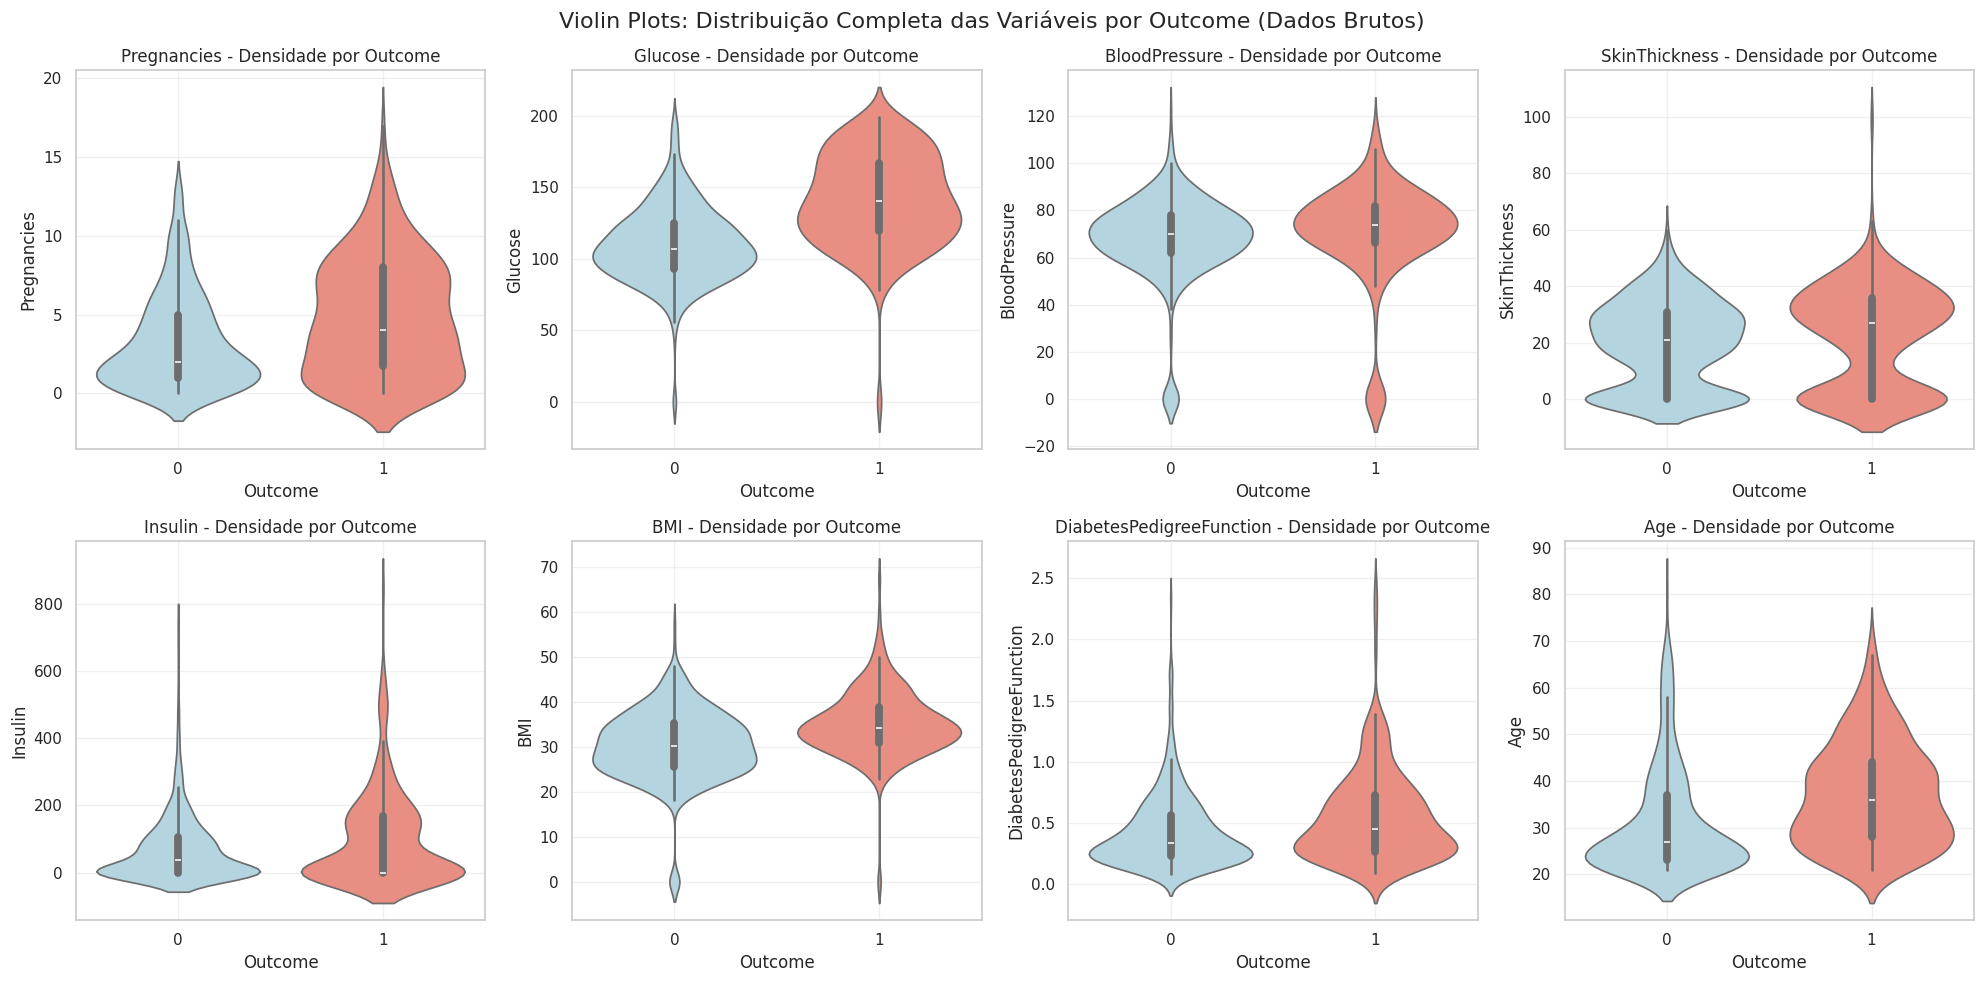

📊 ANÁLISE DOS VIOLIN PLOTS:

💡 INTERPRETAÇÃO DOS GRÁFICOS:
• Violin plots mostram a DENSIDADE de distribuição dos dados
• Largura = maior concentração de valores naquela faixa
• Linha central = mediana
• Permite ver assimetrias e múltiplos picos

🔍 Pregnancies:
   Não Diabético: mediana=2.0, média=3.3
   Diabético: mediana=4.0, média=4.9

🔍 Glucose:
   Não Diabético: mediana=107.0, média=110.0
   Diabético: mediana=140.0, média=141.3

🔍 BloodPressure:
   Não Diabético: mediana=70.0, média=68.2
   Diabético: mediana=74.0, média=70.8

🔍 SkinThickness:
   Não Diabético: mediana=21.0, média=19.7
   Diabético: mediana=27.0, média=22.2

🔍 Insulin:
   Não Diabético: mediana=39.0, média=68.8
   Diabético: mediana=0.0, média=100.3

🔍 BMI:
   Não Diabético: mediana=30.1, média=30.3
   Diabético: mediana=34.2, média=35.1

🔍 DiabetesPedigreeFunction:
   Não Diabético: mediana=0.3, média=0.4
   Diabético: mediana=0.4, média=0.6

🔍 Age:
   Não Diabético: mediana=27.0, média=31.2
   Diabético: median

In [26]:
# Violin Plots usando os dados brutos originais (df) - CORRIGIDO
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(df.select_dtypes(include=[np.number]).columns.drop('Outcome')):
    # Corrigido: usar hue='Outcome' e definir palette corretamente
    sns.violinplot(data=df, x='Outcome', y=col, hue='Outcome', ax=axes[i], 
                   palette=['lightblue', 'salmon'], legend=False)
    axes[i].set_title(f'{col} - Densidade por Outcome')
    axes[i].grid(True, alpha=0.3)
    
    # Remover a legenda duplicada que aparece automaticamente
    if axes[i].get_legend():
        axes[i].get_legend().remove()

plt.suptitle('Violin Plots: Distribuição Completa das Variáveis por Outcome (Dados Brutos)', fontsize=16)
plt.tight_layout()
plt.show()

# Estatísticas descritivas por classe para interpretação
print("📊 ANÁLISE DOS VIOLIN PLOTS:")
print("="*60)
print("\n💡 INTERPRETAÇÃO DOS GRÁFICOS:")
print("• Violin plots mostram a DENSIDADE de distribuição dos dados")
print("• Largura = maior concentração de valores naquela faixa")
print("• Linha central = mediana")
print("• Permite ver assimetrias e múltiplos picos")

for col in df.select_dtypes(include=[np.number]).columns.drop('Outcome'):
    print(f"\n🔍 {col}:")
    for outcome in [0, 1]:
        subset = df[df['Outcome'] == outcome][col]
        outcome_label = "Não Diabético" if outcome == 0 else "Diabético"
        print(f"   {outcome_label}: mediana={subset.median():.1f}, média={subset.mean():.1f}")

## 8. Visualizações Complementares: Boxplots por Classe

Os boxplots abaixo mostram a distribuição de cada variável numérica separada por classe (Outcome: 0 = não diabético, 1 = diabético). Isso ajuda a visualizar diferenças de mediana, dispersão e possíveis outliers entre os grupos.

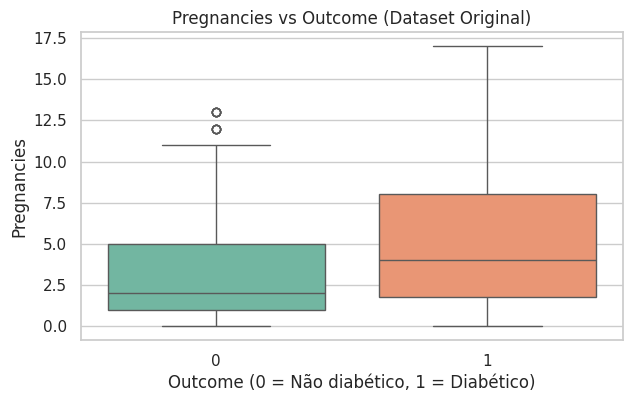

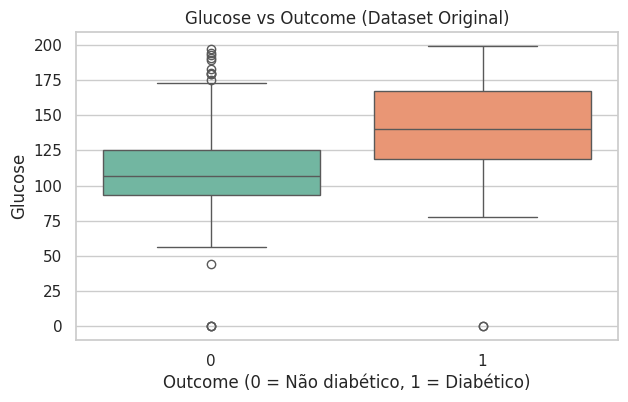

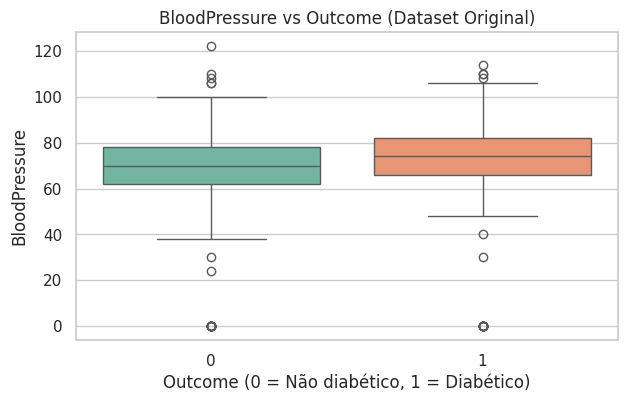

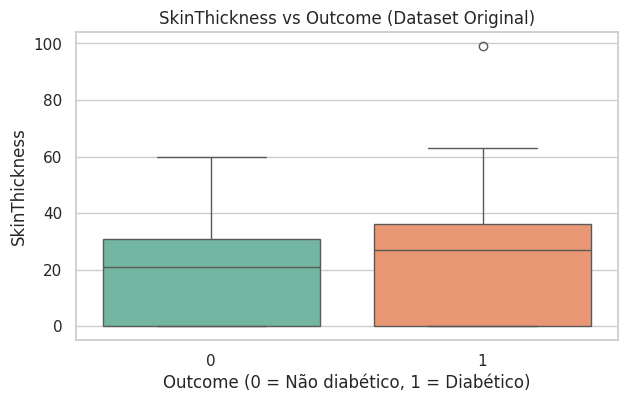

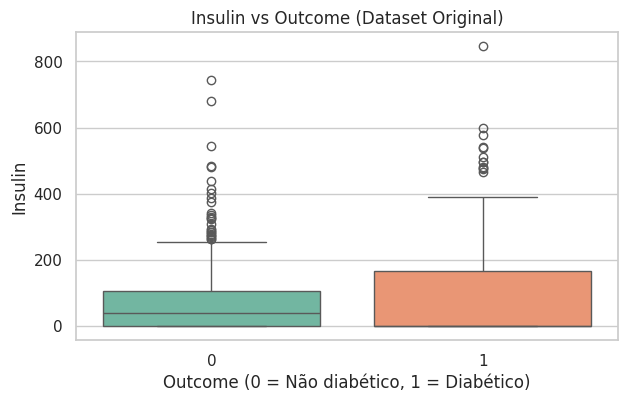

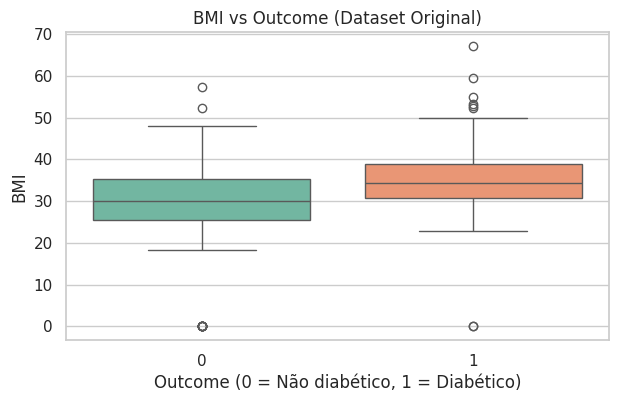

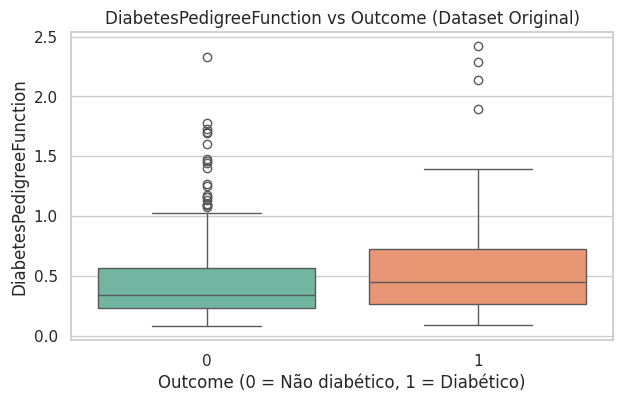

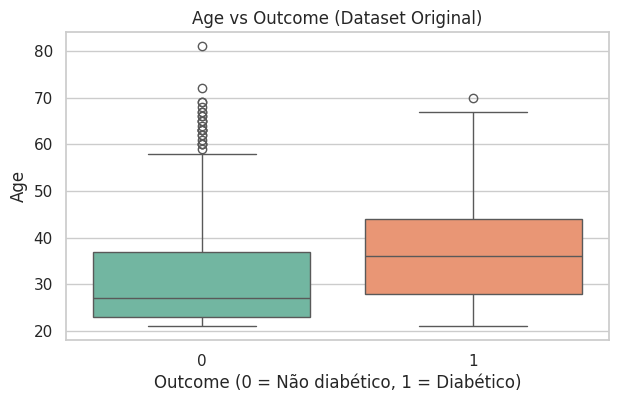


ℹ️ Nota: Boxplots gerados com dataset original para mostrar distribuição natural.
O modelo foi treinado com dados balanceados e sem outliers extremos.


In [47]:
# Exibe boxplots individuais para cada variável numérica vs Outcome
# Usando dataset original para mostrar a distribuição natural dos dados
num_cols = df.columns.drop('Outcome')
for col in num_cols:
    plt.figure(figsize=(7, 4))
    sns.boxplot(x='Outcome', y=col, data=df, hue='Outcome', palette='Set2', legend=False)
    plt.title(f'{col} vs Outcome (Dataset Original)')
    plt.xlabel('Outcome (0 = Não diabético, 1 = Diabético)')
    plt.ylabel(col)
    plt.show()

print("\nℹ️ Nota: Boxplots gerados com dataset original para mostrar distribuição natural.")
print("O modelo foi treinado com dados balanceados e sem outliers extremos.")